# Segmentation of nearly isotropic overlapped tracks in photomicrographs using successive erosions as watershed markers

## Alexandre Fioravante de Siqueira<sup>1,2</sup>, Wagner Massayuki Nakasuga<sup>1</sup>, Sandro Guedes de Oliveira<sup>1</sup>, Lothar Ratschbacher<sup>2</sup>

<sup>1</sup> _Departamento de Raios Cósmicos e Cronologia, IFGW, University of Campinas_

<sup>2</sup> _Institut für Geologie, TU Bergakademie Freiberg_

```
Copyright (C) 2017 Alexandre Fioravante de Siqueira

This file is part of 'Segmentation of nearly isotropic overlapped
tracks in photomicrographs using successive erosions as watershed
markers - Supplementary Material'.

'Segmentation of nearly isotropic overlapped tracks in photomicrographs
using successive erosions as watershed markers - Supplementary Material'
is free software: you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the
Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

'Segmentation of nearly isotropic overlapped tracks in photomicrographs
using successive erosions as watershed markers - Supplementary Material'
is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with 'Segmentation of nearly isotropic overlapped tracks in
photomicrographs using successive erosions as watershed markers -
Supplementary Material'.  If not, see <http://www.gnu.org/licenses/>.
```

## Reproducing this paper and using the supplementary code: a how-to

Thank you for downloading these files. Before using this material, please download this file: <https://dl.dropboxusercontent.com/u/70640911/afdesiqueira2017_figures.zip>. After downloading, please unzip the file and place the contents in the folder containing all Supplementary Code.

The structure of this folder is given at the file `STRUCTURE`. If you have any issues executing this notebook, please check if all subfolders and files are present.

### Installing Python

* If you do not have Python and the necessary modules installed on your PC, please install Anaconda before using this how-to: <https://www.continuum.io/downloads>. Download the suitable package according to your system, and install it following the page instructions. We use Python 3 for implementing and running this code.

### Importing the necessary modules

* This code is based on several Python modules. We need to import them before their use.

In [1]:
from itertools import product
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from scipy.stats import norm
from scipy.ndimage.morphology import binary_fill_holes
from skimage.filters import threshold_isodata
from skimage.io import imread
from skimage.measure import regionprops
from sys import platform

import matplotlib.mlab as mlab
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics as stats
import warnings

* Now we import the functions presented in this study. They are inside the file `desiqueira2017.py`; please ensure that you are executing this how-to in the same folder as these functions, or the following command will return an error. 

In [2]:
import desiqueira2017 as ds

### Calling support functions

* This how-to depends on some functions to generate results and to help plotting data, which are distributed with the supplementary material. Here we call all these functions.

In [3]:
import supmat_support as sup

### Some settings

* Here we establish a default font size, modify the resulting plots, ask to Matplotlib draw them on this how-to (and not on a separate window), and disable all warnings that could be generated. Since we will work with a large number of images, this is useful to avoid the several warnings that would appear.

In [4]:
default_fontsize = 15

plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
plt.rcParams['axes.titlesize'] = 1.5*plt.rcParams['font.size']
plt.rcParams['legend.fontsize'] = 1.5*plt.rcParams['font.size']
plt.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
plt.rcParams['ytick.labelsize'] = plt.rcParams['font.size']

%matplotlib inline
warnings.filterwarnings('ignore')

## An example of the WUSEM segmentation

* Here we repeat the example generated from _Figure 1_. First we read an image using `imread()`. Then, we use the function `wusem_results()`, which presents the ISODATA threshold and WUSEM segmentation results. We obtain also the threshold value and the number of counted tracks.

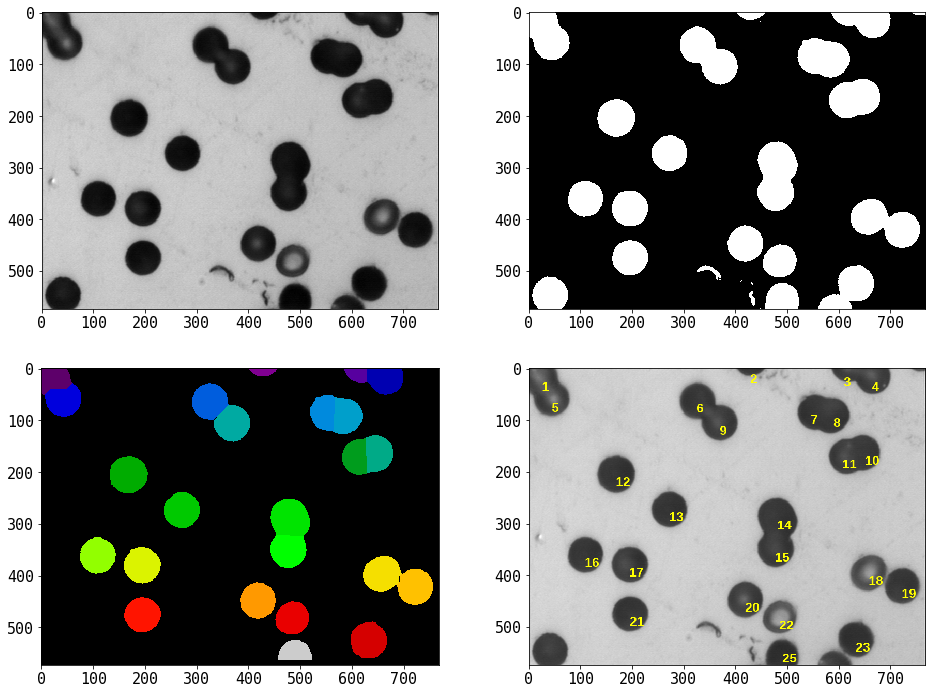

Threshold:  134
Number of tracks:  28


In [5]:
image = imread('figures/orig_figures/dataset_01/Kr-78_4,5min/K90_incid/K90_incid4,5min_6.bmp', as_grey=True)
num_objects = sup.wusem_results(image, initial_radius=10, delta_radius=2, save_images=False)
print('Threshold: ', threshold_isodata(image))
print('Number of tracks: ', num_objects)

## Reading manual and WUSEM counting

* In the next commands, we define some helping variables, we count the generated data in the previous line, and we separate the resulting data in folders, according to the coating amount of each sample. For more information on coating amounts, please refer to the paper. If you do not want to execute the previous command, its results are already included in the supplementary code.

In [6]:
# some helping variables.
samples = ['0', '20', '30', '40', '50', '60', '70', '80', '90']
folders = ['K0_incid', 'K20_incid', 'K30_incid', 'K40_incid', 'K50_incid',
           'K60_incid', 'K70_incid', 'K80_incid', 'K90_incid']

# reading input data.
man_count_45 = pd.read_excel('counting/manual_count/manual_dataset01_Kr-78_4,5min_incid.xls')
wusem_count_45 = pd.read_csv('counting/wusem_count/auto_dataset01_Kr-78_4,5min_incid.txt')
man_count_85 = pd.read_excel('counting/manual_count/manual_dataset01_Kr-78_8,5min_incid.xls')
wusem_count_85 = pd.read_csv('counting/wusem_count/auto_dataset01_Kr-78_8,5min_incid.txt')

# separating folders.
manual_45, wusem_45, manual_85, wusem_85 = [{} for _ in range(4)]

for idx, folder in enumerate(folders):
    manual_45[samples[idx]] = man_count_45[man_count_45['folder'] == folder]
    wusem_45[samples[idx]] = wusem_count_45[wusem_count_45['folder'] == folder]
    manual_85[samples[idx]] = man_count_85[man_count_85['folder'] == folder]
    wusem_85[samples[idx]] = wusem_count_85[wusem_count_85['folder'] == folder]

* Now we check the effects of variating `initial_radius` and `delta_radius`, and plot the results.

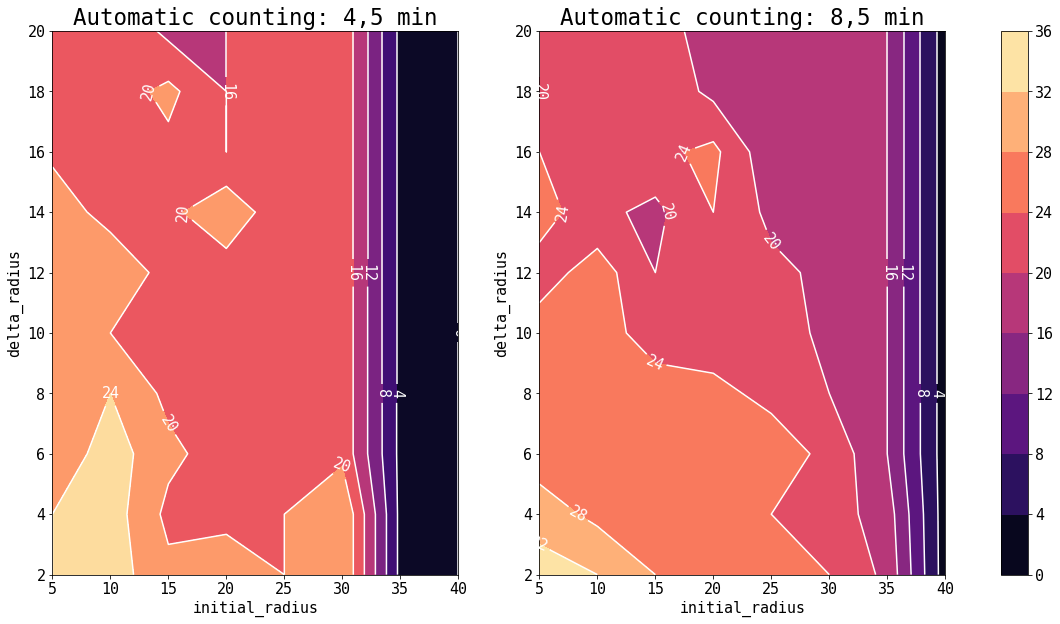

In [7]:
# helping plot variables.
x_ticks = ['5', '10', '15', '20', '25', '30', '35', '40']
y_ticks = ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20']

# separating a test image.
autotest_45 = wusem_count_45[(wusem_count_45['folder'] == 'K90_incid') &
                           (wusem_count_45['image'] == 1)]
autotest_85 = wusem_count_85[(wusem_count_85['folder'] == 'K90_incid') &
                           (wusem_count_85['image'] == 1)]

# initial_radius starts in 5, ends in 40 and has delta_radius 5.
# delta_radius starts in 2, ends in 20 and has delta_radius 2.
# first, we create matrices to accomodate the countings.
XX, YY = np.mgrid[5:41:5, 2:21:2]
ZZtest_auto45, ZZtest_auto85 = [np.zeros(XX.shape) for _ in range(2)]

for i, j in product(range(5, 41, 5), range(2, 21, 2)):
    aux = int(autotest_45.auto_count[(wusem_count_45.initial_radius == i) &
                                     (wusem_count_45.delta_radius == j)])
    ZZtest_auto45[(XX == i) & (YY == j)] = aux

    aux = int(autotest_85.auto_count[(wusem_count_85.initial_radius == i) &
                                     (wusem_count_85.delta_radius == j)])
    ZZtest_auto85[(XX == i) & (YY == j)] = aux

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

image = axes[0].contour(ZZtest_auto45.T, colors='w')
axes[0].clabel(image, fmt='%i', fontsize=default_fontsize)
image = axes[0].contourf(ZZtest_auto45.T, cmap='magma')
axes[0].set_title('Automatic counting: 4,5 min')

image = axes[1].contour(ZZtest_auto85.T, colors='w')
axes[1].clabel(image, fmt='%i', fontsize=default_fontsize)
image = axes[1].contourf(ZZtest_auto85.T, cmap='magma')
axes[1].set_title('Automatic counting: 8,5 min')

for ax in axes.ravel():
    ax.set_xlabel('initial_radius')
    ax.set_ylabel('delta_radius')
    ax.set_xticklabels(x_ticks)
    ax.set_yticklabels(y_ticks)

fig.colorbar(image, ax=axes.ravel().tolist(), orientation='vertical')

### Selecting the best candidates for `initial_radius` and `delta_radius`

* Here we calculate the means for manual counting, and obtain the best candidates for `initial_radius` and `delta_radius`. We also separate them according to the two scenarios: considering and ignoring border tracks, and the etching times.

In [8]:
# calculating the means for manual counting, and obtaining the candidates for initial_radius and delta_radius.
mean_tol = 2  # defining tolerance
meanman_45, meanman_85 = [{} for _ in range(2)]
cand_wusem_45, cand_wusem_85 = [{} for _ in range(2)]

for key, val in manual_45.items():
    # candidates for 4,5 min.
    meanman_45[key] = val.manual_count.mean()
    cand_wusem_45[key] = ds.comp_wusem_counting(meanman_45[key],
                                                wusem_45[key],
                                                tolerance=mean_tol)

for key, val in manual_85.items():
    # candidates for 8,5 min.
    meanman_85[key] = val.manual_count.mean()
    cand_wusem_85[key] = ds.comp_wusem_counting(meanman_85[key],
                                                wusem_85[key],
                                                tolerance=mean_tol)

* Here we present the manual mean counting for each sample, scenario and etching time. We also present the `initial_radius`, `delta_radius` candidates in order, and for how many samples it was inside the tolerance interval: the first candidate is the best for that sample. 

In [9]:
print('* Means for manual counting (4.5 min):\n', meanman_45)
for cand in ds.sorting_candidates(ds.joining_candidates(cand_wusem_45)):
    print('Candidate: ', cand[0], ', Samples: ', cand[1])
print('\n')

print('* Means for manual counting (8.5 min):\n', meanman_85)
for cand in ds.sorting_candidates(ds.joining_candidates(cand_wusem_85)):
    print('Candidate: ', cand[0], ', Samples: ', cand[1])
print('\n')

* Means for manual counting (4.5 min):
 {'0': 21.55, '20': 25.35, '30': 23.2, '40': 22.45, '50': 24.35, '60': 25.1, '70': 20.65, '80': 20.55, '90': 23.545454545454547}
Candidate:  [10, 20] , Samples:  8
Candidate:  [5, 16] , Samples:  7
Candidate:  [5, 18] , Samples:  7
Candidate:  [5, 20] , Samples:  7
Candidate:  [10, 6] , Samples:  7
Candidate:  [10, 8] , Samples:  7
Candidate:  [10, 12] , Samples:  7
Candidate:  [10, 16] , Samples:  7
Candidate:  [10, 18] , Samples:  7
Candidate:  [20, 2] , Samples:  7
Candidate:  [10, 10] , Samples:  6
Candidate:  [15, 4] , Samples:  6
Candidate:  [15, 8] , Samples:  6
Candidate:  [15, 16] , Samples:  6
Candidate:  [15, 6] , Samples:  6
Candidate:  [5, 10] , Samples:  5
Candidate:  [5, 14] , Samples:  5
Candidate:  [10, 14] , Samples:  5
Candidate:  [15, 2] , Samples:  5
Candidate:  [15, 14] , Samples:  5
Candidate:  [20, 4] , Samples:  5
Candidate:  [10, 4] , Samples:  4
Candidate:  [5, 8] , Samples:  3
Candidate:  [5, 12] , Samples:  3
Candidate

* Now we plot the manual means, the tolerance interval, and the candidates for each sample. Candidates within and outside the tolerance interval are shown in orange and gray, respectively. 

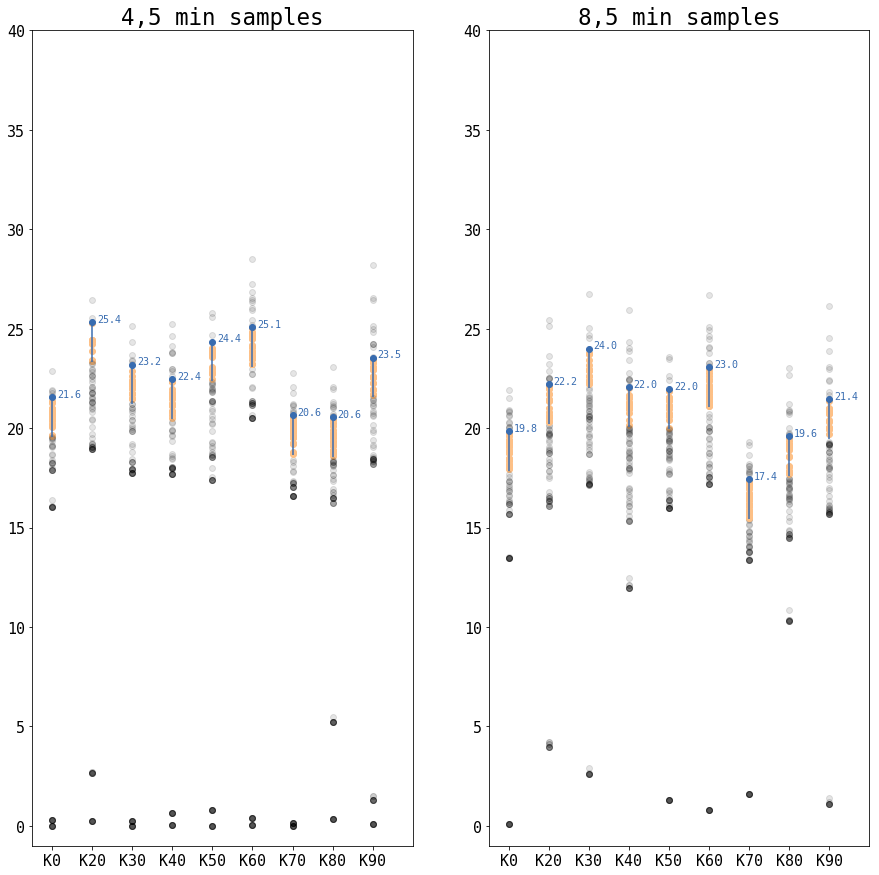

In [10]:
# supporting variables.
man_color = '#386cb0'
wusem_color = '#fdc086'

plot_where = {'0': 10, '20': 20, '30': 30, '40': 40, '50': 50,
                 '60': 60, '70': 70, '80': 80, '90': 90}

x_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90]
x_labels = ['K0', 'K20', 'K30', 'K40', 'K50', 'K60', 'K70', 'K80', 'K90']

# the actual plots.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

for key, val in meanman_45.items():
    axes[0].errorbar(plot_where[key], val, yerr=np.array([[mean_tol, 0]]).T, marker='o', color=man_color)
    axes[0].annotate(np.round(val, decimals=1), xy=(plot_where[key]+1.2, val), color=man_color)
    axes[0].set_title('4,5 min samples')

for key, val in meanman_85.items():
    axes[1].errorbar(plot_where[key], val, yerr=np.array([[mean_tol, 0]]).T, marker='o', color=man_color)
    axes[1].annotate(np.round(val, decimals=1), xy=(plot_where[key]+1.2, val), color=man_color)
    axes[1].set_title('8,5 min samples')

for i, j in product(range(5, 41, 5), range(2, 21, 2)):
    for key, val in wusem_45.items():
        aux_wb = val.auto_count[(val.initial_radius == i) & (val.delta_radius == j)].mean()
        if 0 < (meanman_45[key] - aux_wb) < mean_tol:
            axes[0].scatter(plot_where[key], aux_wb, color=wusem_color)
        else:
            axes[0].scatter(plot_where[key], aux_wb, color='k', alpha=0.1)

    for key, val in wusem_85.items():
        aux_wb = val.auto_count[(val.initial_radius == i) & (val.delta_radius == j)].mean()
        if 0 < (meanman_85[key] - aux_wb) < mean_tol:
            axes[1].scatter(plot_where[key], aux_wb, color=wusem_color)
        else:
            axes[1].scatter(plot_where[key], aux_wb, color='k', alpha=0.1)

for ax in axes.ravel():
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    ax.set_xlim([5, 100])
    ax.set_ylim([-1, 40])

* According to the previous information, we define the best arguments:

In [11]:
bestarg_45 = (10, 20)
bestarg_85 = (10, 14)

* Considering the best automatic counting, we now have the manual/auto ratio for each sample, scenario and etching time.  

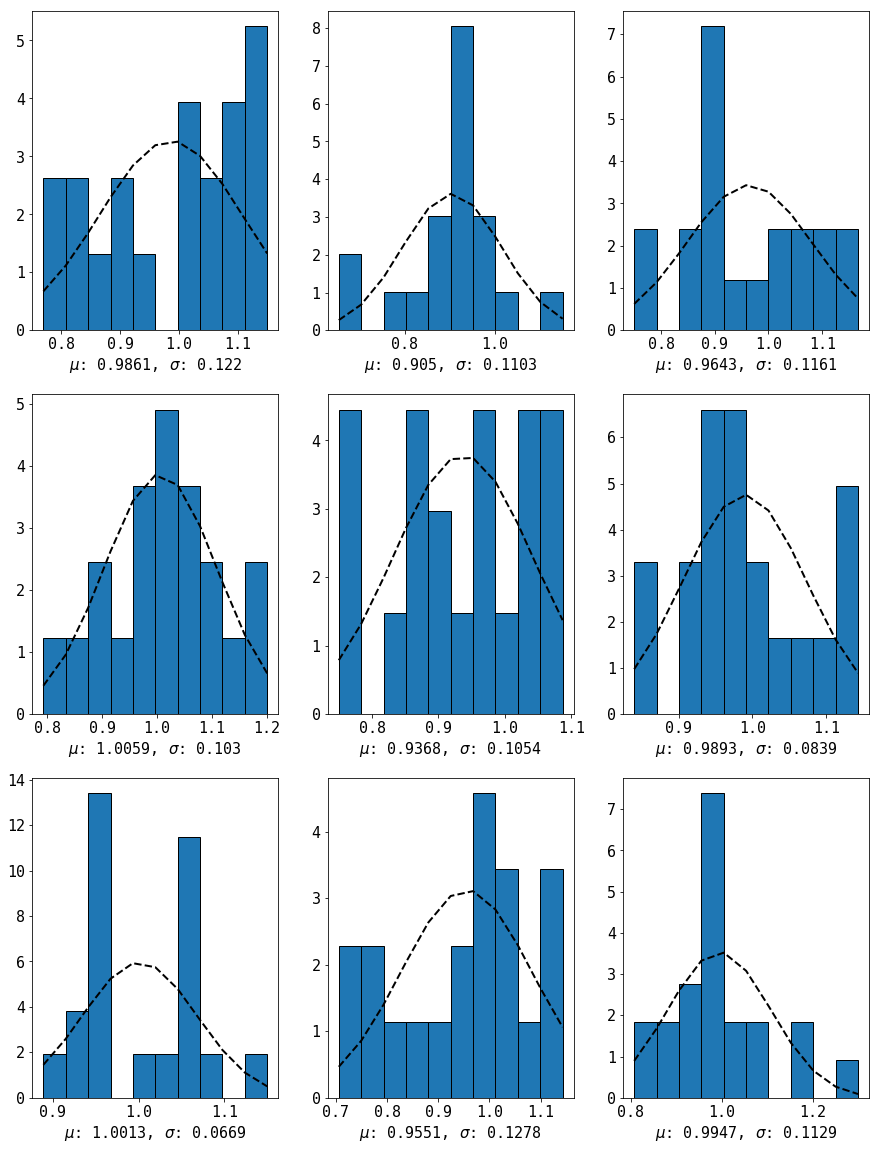

['0', 0.9860763070716295, 0.12201688060276179]
['20', 0.9050257906691564, 0.11033078275663029]
['30', 0.964322029120962, 0.11608978892352319]
['40', 1.0059346080951084, 0.10302155738959316]
['50', 0.9368185986094533, 0.10543004073194194]
['60', 0.9893135409515758, 0.08387253556625841]
['70', 1.001254260391274, 0.06686760382765347]
['80', 0.9550969867205229, 0.12777805602833767]
['90', 0.9946966795863804, 0.11288117336386233]


In [12]:
# 4.5 minutes:
wusem_best_45 = {}

for key, val in wusem_45.items():
    wusem_best_45[key] = val[(val['initial_radius'] == bestarg_45[0]) &
                             (val['delta_radius'] == bestarg_45[1])]

ratio = ds.ratio_manauto(manual_45, wusem_best_45)

# the values of mu and sigma for each sample:
for rt in ratio:
    print(rt)

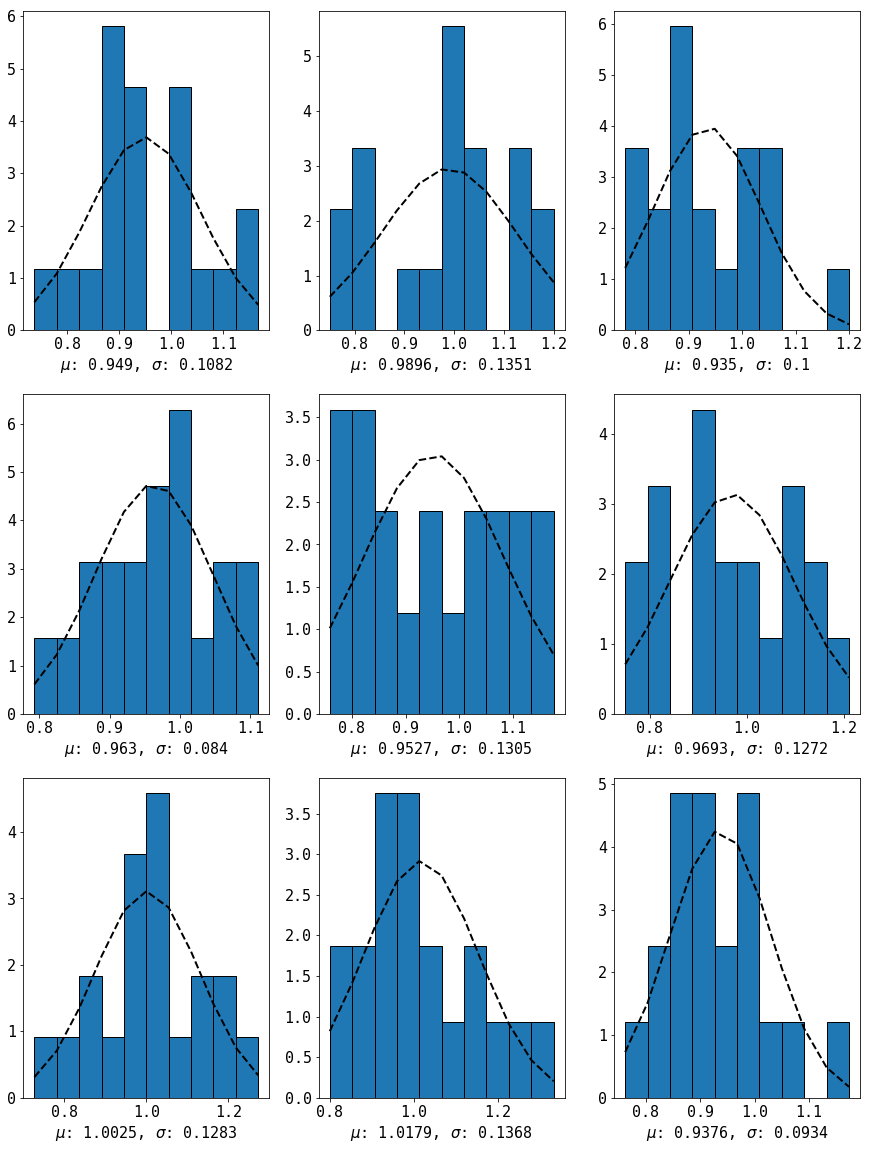

['0', 0.9490152474766823, 0.10816198003042429]
['20', 0.9896175882646912, 0.13511925087193064]
['30', 0.9349719733556977, 0.09999982763557407]
['40', 0.9630225605905581, 0.08396253828234397]
['50', 0.9526592291398636, 0.13045088627617096]
['60', 0.9693356560705461, 0.12716957866905165]
['70', 1.0024788348762808, 0.12832559508383376]
['80', 1.017925032410394, 0.13679745487828587]
['90', 0.9376020638923451, 0.0934444327679423]


In [13]:
# 8.5 minutes:
wusem_best_85 = {}

for key, val in wusem_85.items():
    wusem_best_85[key] = val[(val['initial_radius'] == bestarg_85[0]) &
                             (val['delta_radius'] == bestarg_85[1])]

ratio = ds.ratio_manauto(manual_85, wusem_best_85)

# the values of mu and sigma for each sample:
for rt in ratio:
    print(rt)

* Now we compare the counting and fit for all samples separated. In the paper, we have all information in two plots.

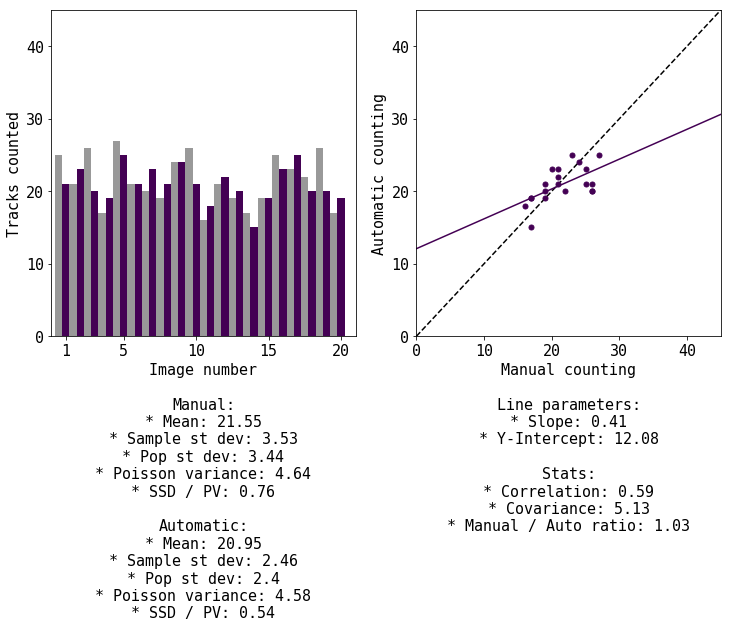

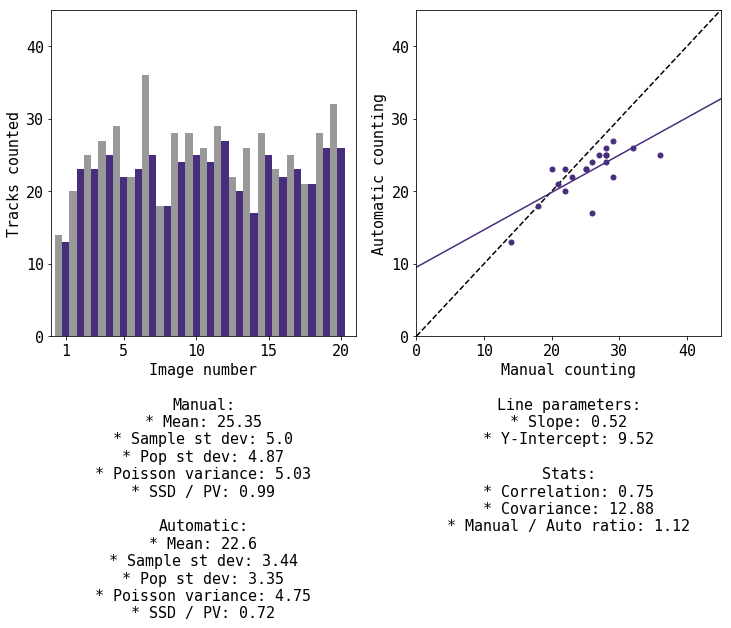

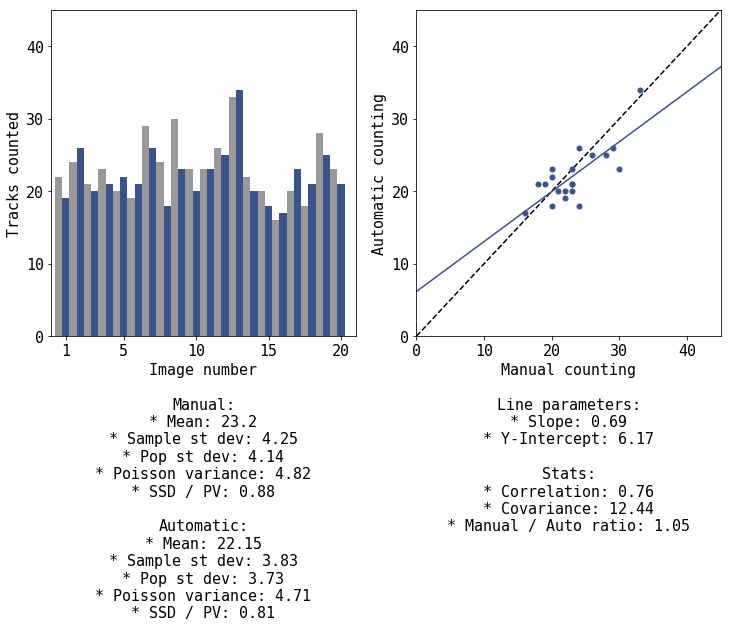

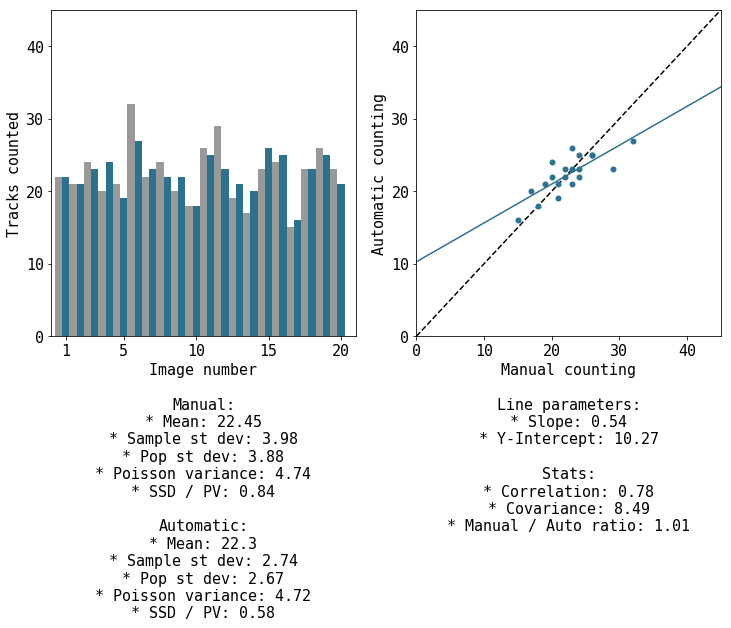

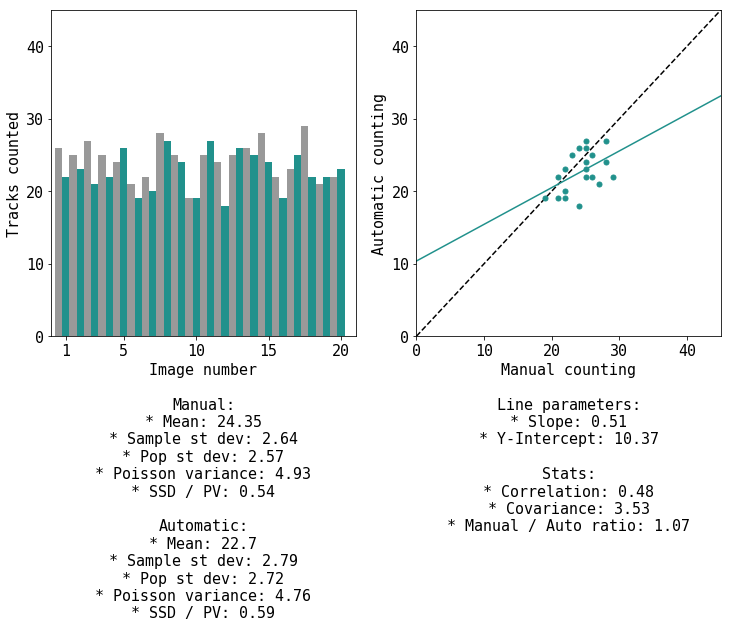

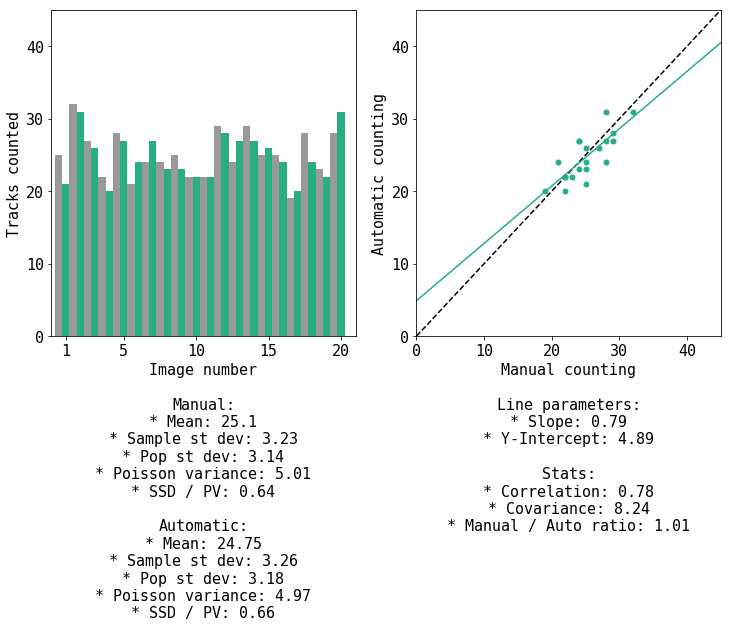

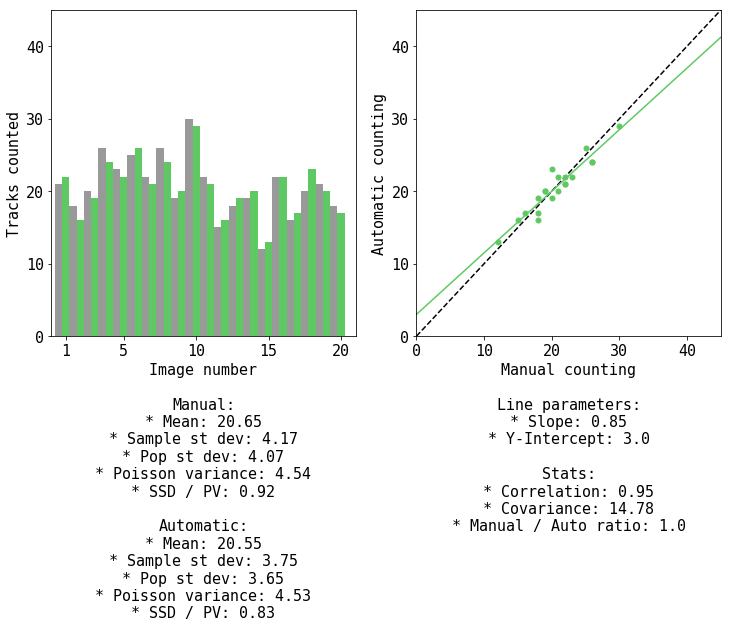

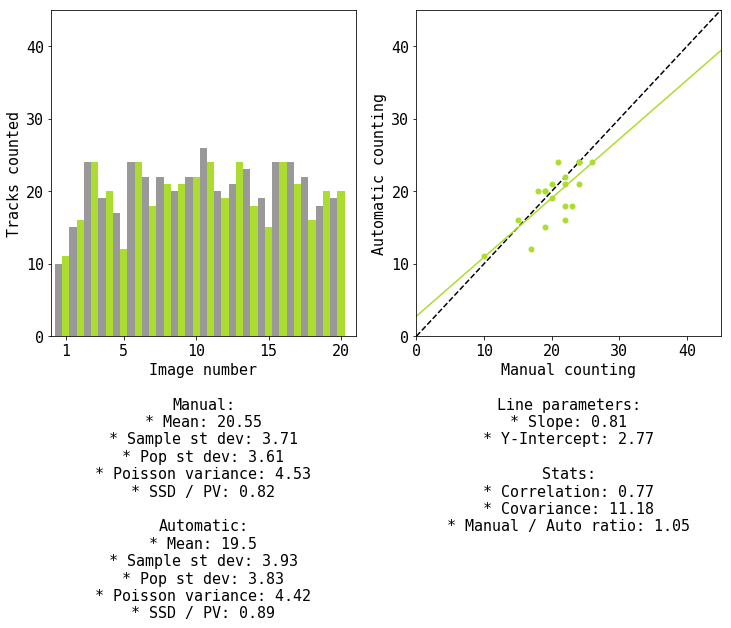

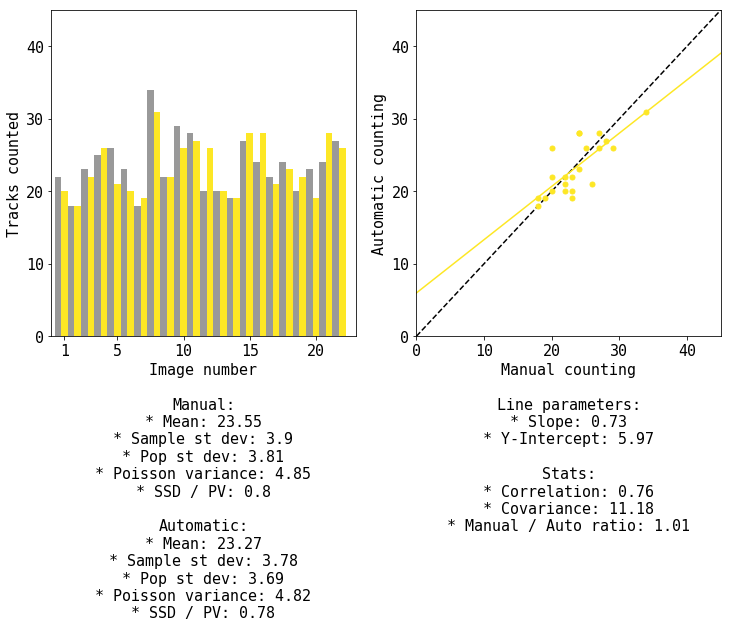

In [14]:
# 4.5 min.
# supporting variables
plot_where = {'0': 0, '20': 1, '30': 2, '40': 3, '50': 4,
              '60': 5, '70': 6, '80': 7, '90': 8}

plot_colors = {'0': '#440154', '20': '#472d7b', '30': '#3b528b',
               '40': '#2c728e', '50': '#21918c', '60': '#28ae80',
               '70': '#5ec962', '80': '#addc30', '90': '#fde725'}

# the actual plots.
for key, val in manual_45.items():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sup.plot_auxiliar_dataset1(var_manual=val.manual_count,
                               var_auto=wusem_best_45[key].auto_count,
                               auto_color=plot_colors[key],
                               ax=ax[0])

    sup.plot_linreg_dataset1(var_manual=val.manual_count,
                             var_auto=wusem_best_45[key].auto_count,
                             color=plot_colors[key],
                             ax=ax[1])

    ax[1].axis([0, 45, 0, 45])

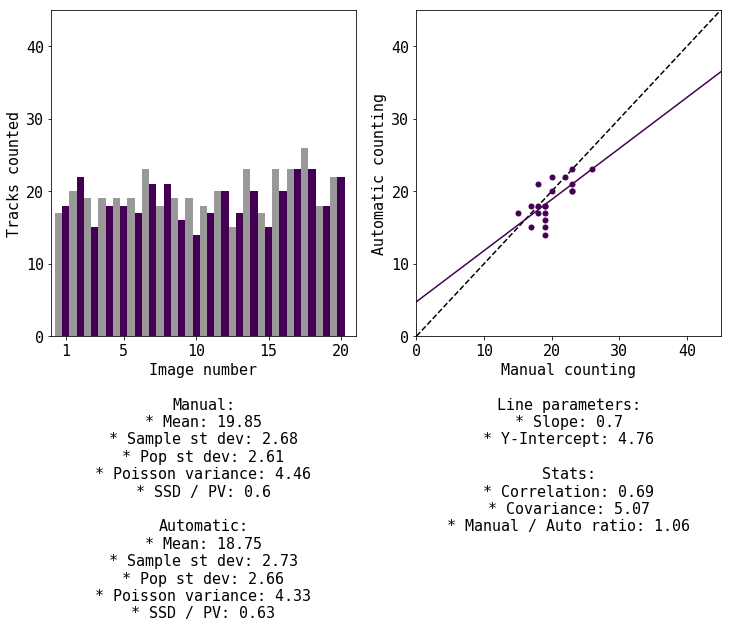

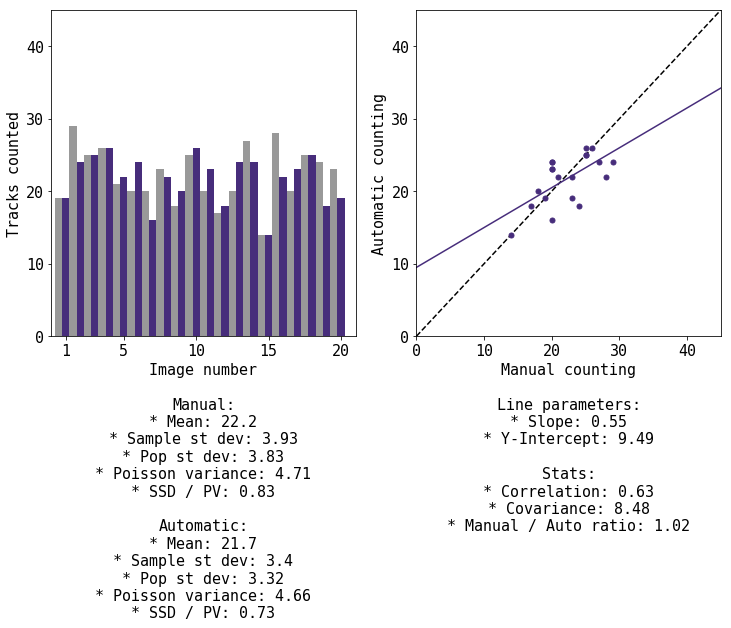

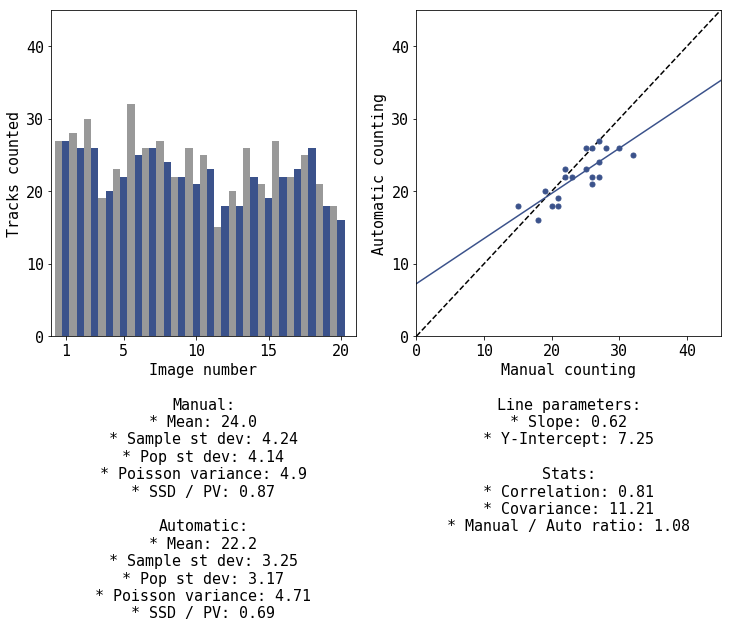

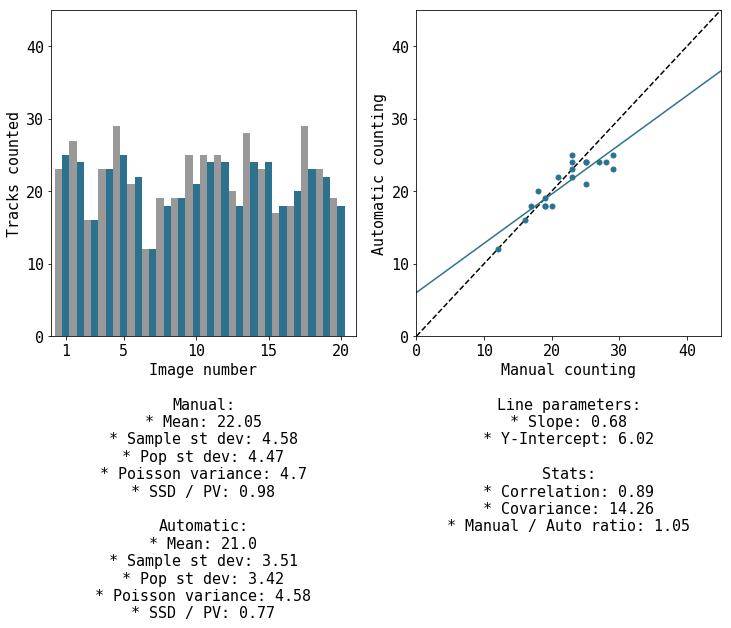

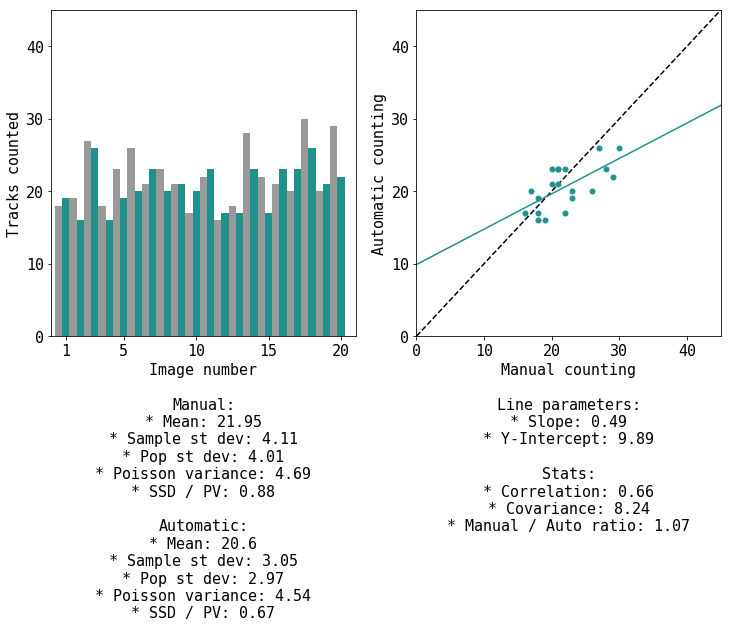

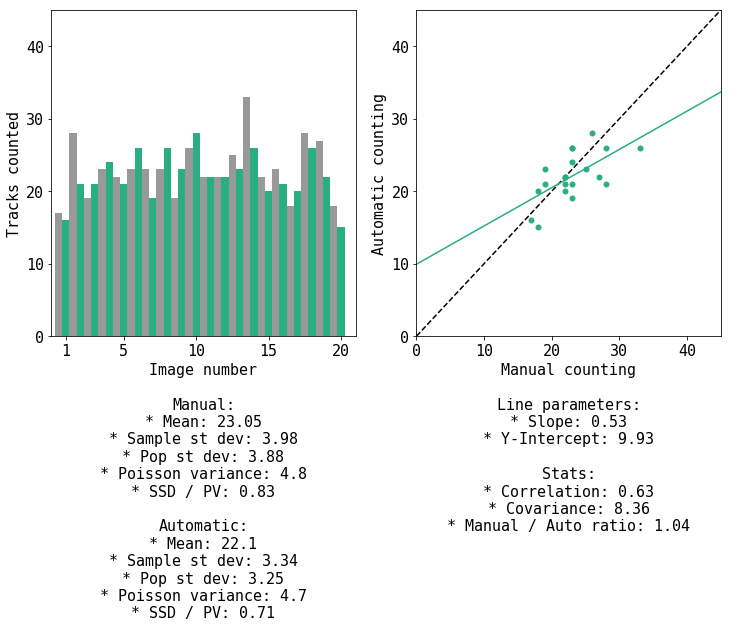

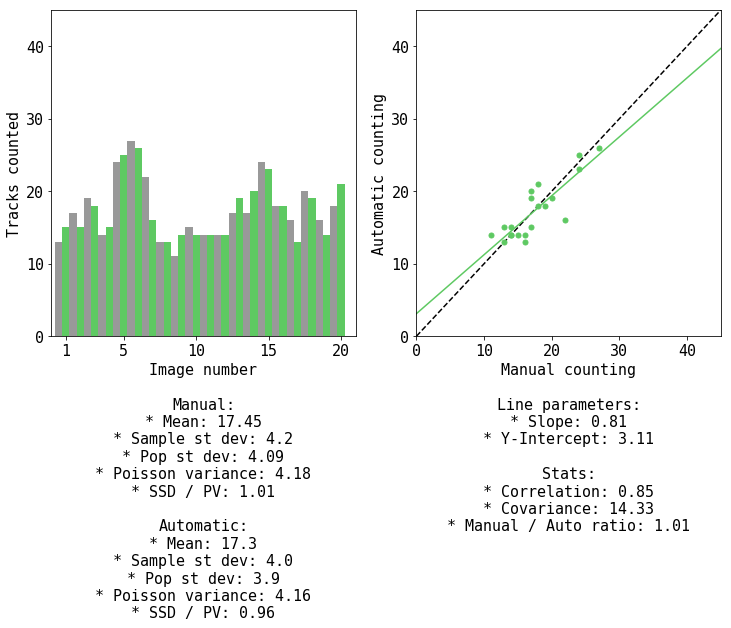

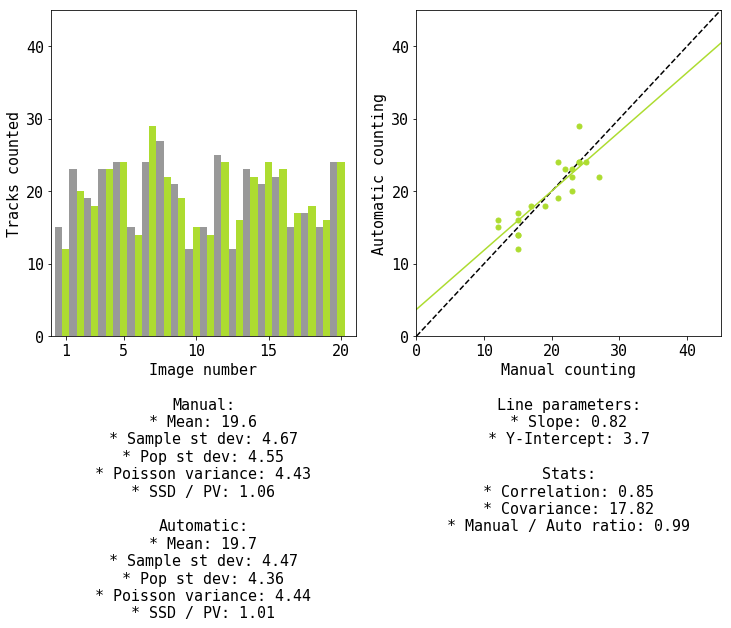

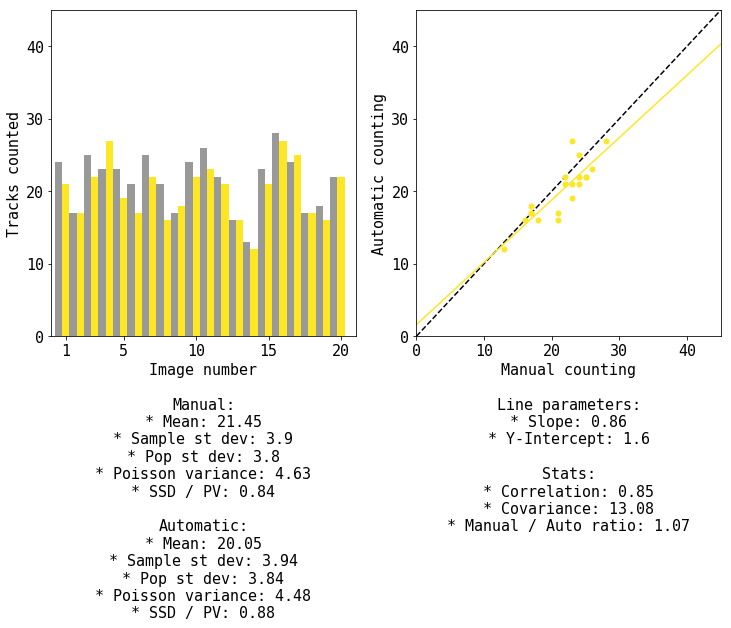

In [15]:
# 8.5 min.
# supporting variables
plot_where = {'0': 0, '20': 1, '30': 2, '40': 3, '50': 4,
              '60': 5, '70': 6, '80': 7, '90': 8}

plot_colors = {'0': '#440154', '20': '#472d7b', '30': '#3b528b',
               '40': '#2c728e', '50': '#21918c', '60': '#28ae80',
               '70': '#5ec962', '80': '#addc30', '90': '#fde725'}

# the actual plots.
for key, val in manual_85.items():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sup.plot_auxiliar_dataset1(var_manual=val.manual_count,
                               var_auto=wusem_best_85[key].auto_count,
                               auto_color=plot_colors[key],
                               ax=ax[0])

    sup.plot_linreg_dataset1(var_manual=val.manual_count,
                             var_auto=wusem_best_85[key].auto_count,
                             color=plot_colors[key],
                             ax=ax[1])

    ax[1].axis([0, 45, 0, 45])

* We can compare the mean and standard deviation achieved by manual and automatic counting for each sample.

In [16]:
# comparing manual/auto mean and std
print('* Manual, dataset 01, 4.5 min')
for key, val in manual_45.items():
    print(key, ':', ds.parameters_samples(val.manual_count))
print('\n')

print('* Auto, dataset 01, 4.5 min')
for key, val in wusem_best_45.items():
    print(key, ':', ds.parameters_samples(val.auto_count))
print('\n')

print('* Manual, dataset 01, 8.5 min')
for key, val in manual_85.items():
    print(key, ':', ds.parameters_samples(val.manual_count))
print('\n')

print('* Auto, dataset 01, 8.5 min')
for key, val in wusem_best_85.items():
    print(key, ':', ds.parameters_samples(val.auto_count))
print('\n')

* Manual, dataset 01, 4.5 min
0 : [21.55, 3.4420197558991434]
20 : [25.35, 4.871088174114692]
30 : [23.2, 4.1424630354415966]
40 : [22.45, 3.8791107228332633]
50 : [24.35, 2.5743931323712004]
60 : [25.1, 3.144837038703278]
70 : [20.65, 4.065402809070708]
80 : [20.55, 3.6121323342314025]
90 : [23.545454545454547, 3.810598530024489]


* Auto, dataset 01, 4.5 min
0 : [20.95, 2.3973944189473704]
20 : [22.6, 3.3526109228480423]
30 : [22.15, 3.7319565913874184]
40 : [22.3, 2.666458325194677]
50 : [22.7, 2.72213151776324]
60 : [24.75, 3.1760824926314495]
70 : [20.55, 3.653423052426313]
80 : [19.5, 3.8275318418009276]
90 : [23.272727272727273, 3.6949820787093772]


* Manual, dataset 01, 8.5 min
0 : [19.85, 2.612948526090784]
20 : [22.2, 3.8288379438153295]
30 : [24.0, 4.135214625627067]
40 : [22.05, 4.466262419518136]
50 : [21.95, 4.00593309979086]
60 : [23.05, 3.879110722833263]
70 : [17.45, 4.09237095092808]
80 : [19.6, 4.5541190146942805]
90 : [21.45, 3.800986713999406]


* Auto, dataset 01

* After finding the best algorithms and comparing the results, we define variables to store them.

In [17]:
man_count = pd.read_excel('counting/manual_count/manual_dataset01_Kr-78_4,5min_incid.xls')
wusem_count = pd.read_csv('counting/wusem_count/auto_dataset01_Kr-78_4,5min_incid.txt')
manual, wusem, wusem_best = [{} for _ in range(3)]

for idx, folder in enumerate(folders):
    manual[samples[idx]] = man_count[man_count['folder'] == folder]
    wusem[samples[idx]] = wusem_count[wusem_count['folder'] == folder]

for key, val in wusem.items():
    # best candidate.
    wusem_best[key] = val[(val['initial_radius'] == bestarg_45[0]) &
                          (val['delta_radius'] == bestarg_45[1])]

## Relating track energies with shades of gray and diameters

* To obtain information about shades of gray and diameters, we can define eccentricity and discriminate the "most rounded regions of interest" in the image. First we read the image, then we use the function `round_regions()` with the best arguments.

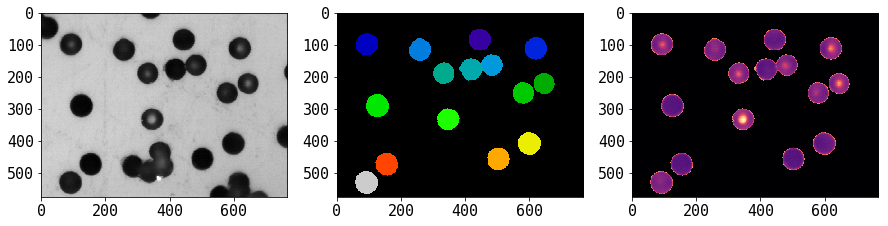

In [18]:
image = imread('figures/orig_figures/dataset_01/Kr-78_4,5min/K90_incid/K90_incid4,5min_3.bmp',
               as_grey=True)

labels, objects, info_reg = ds.round_regions(image,
                                             initial_radius=bestarg_45[0],
                                             delta_radius=bestarg_45[1],
                                             toler_ecc=0.3)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(labels, cmap='nipy_spectral')
ax[2].imshow(objects, cmap='magma')
plt.show()

properties = regionprops(labels, intensity_image=image)

### Acquiring and saving data for round objects

* Here we acquire and save the data for round objects within each image. Please uncomment the lines (remove the #) to run each command. If you do not want to run the following command, the results are present in the supplementary material.

In [19]:
# sample_set = ['Kr-78_4,5min', 'Kr-78_8,5min']
# ds.all_round_regions(sample_set, initial_radius=5, delta_radius=4, eccentricity=0.3)

# Work in progress...

In [20]:
incid_energy = {'0': 865, '20': 701, '30': 613, '40': 520, '50': 422,
                '60': 320, '70': 213, '80': 105, '90': 18}

In [21]:
wuseminfo_45 = pd.read_csv('counting/wusem_count/roundinfo_dataset01_Kr-78_4,5min.txt')
wuseminfo_85 = pd.read_csv('counting/wusem_count/roundinfo_dataset01_Kr-78_8,5min.txt')

wusem_45, wusem_85 = [{} for _ in range(2)]
for idx, folder in enumerate(folders):
    wusem_45[samples[idx]] = wuseminfo_45[wuseminfo_45['folder'] == folder]
    wusem_85[samples[idx]] = wuseminfo_85[wuseminfo_85['folder'] == folder]

In [22]:
rows, cols = 3, 3

which_to_plot = {'[0, 0]': '0', '[0, 1]': '20', '[0, 2]': '30',
                 '[1, 0]': '40', '[1, 1]': '50', '[1, 2]': '60',
                 '[2, 0]': '70', '[2, 1]': '80', '[2, 2]': '90'}

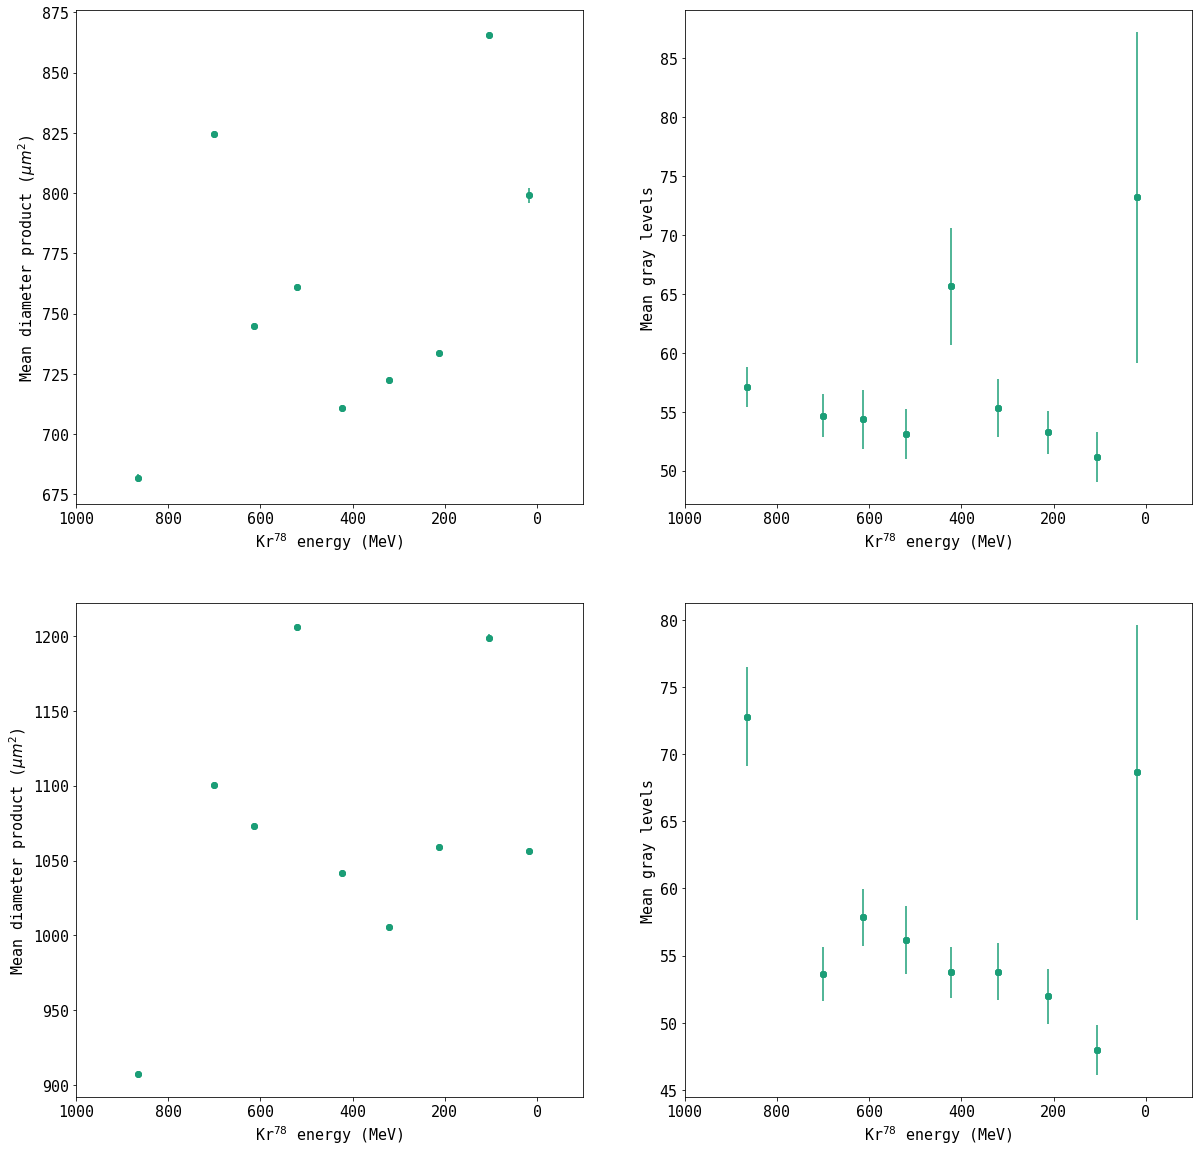

In [23]:
data_45, data_85 = [{} for _ in range(2)]
plot_colors = ['#1b9e77', '#d95f02']
border = []

for color in plot_colors:
    border.append(mpatches.Patch(color=color))

for idx, folder in enumerate(folders):
    data_45[samples[idx]] = wuseminfo_45[wuseminfo_45['folder'] == folder]
    data_85[samples[idx]] = wuseminfo_85[wuseminfo_85['folder'] == folder]

data_wusem45 = [data_45]
data_wusem85 = [data_85]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

for idx, data in enumerate(data_wusem45):
    for key, val in data.items():
        axes[0, 0].scatter(incid_energy[key],
                           ds.px_to_um2(val['minor_axis'].mean(),
                                        val['major_axis'].mean()),
                           marker='o', color=plot_colors[idx])
        axes[0, 0].errorbar(incid_energy[key],
                            ds.px_to_um2(val['minor_axis'].mean(),
                                         val['major_axis'].mean()),
                            yerr=ds.px_to_um2(val['minor_axis'].std(),
                                              val['major_axis'].std()),
                            marker='o', color=plot_colors[idx])
        axes[0, 0].set_ylabel('Mean diameter product ($\mu m^2$)')

        axes[0, 1].scatter(incid_energy[key], val['mean_gray'].mean(),
                           marker='X', color=plot_colors[idx])
        axes[0, 1].errorbar(incid_energy[key], val['mean_gray'].mean(),
                            yerr=val['mean_gray'].std(), marker='o',
                            color=plot_colors[idx])
        axes[0, 1].set_ylabel('Mean gray levels')

for idx, data in enumerate(data_wusem85):
    for key, val in data.items():
        axes[1, 0].scatter(incid_energy[key],
                           ds.px_to_um2(val['minor_axis'].mean(),
                                        val['major_axis'].mean()),
                           marker='o', color=plot_colors[idx])
        axes[1, 0].errorbar(incid_energy[key],
                            ds.px_to_um2(val['minor_axis'].mean(),
                                        val['major_axis'].mean()),
                            yerr=ds.px_to_um2(val['minor_axis'].std(),
                                              val['major_axis'].std()),
                            marker='o', color=plot_colors[idx])
        axes[1, 0].set_ylabel('Mean diameter product ($\mu m^2$)')

        axes[1, 1].scatter(incid_energy[key], val['mean_gray'].mean(),
                           marker='X', color=plot_colors[idx])
        axes[1, 1].errorbar(incid_energy[key], val['mean_gray'].mean(),
                            yerr=val['mean_gray'].std(), marker='o',
                            color=plot_colors[idx])
        axes[1, 1].set_ylabel('Mean gray levels')

for ax in axes.ravel():
    ax.set_xlim([-100, 1000])
    ax.set_xlabel('Kr$^{78}$ energy (MeV)')
    ax.invert_xaxis()

# Processing DAP images.

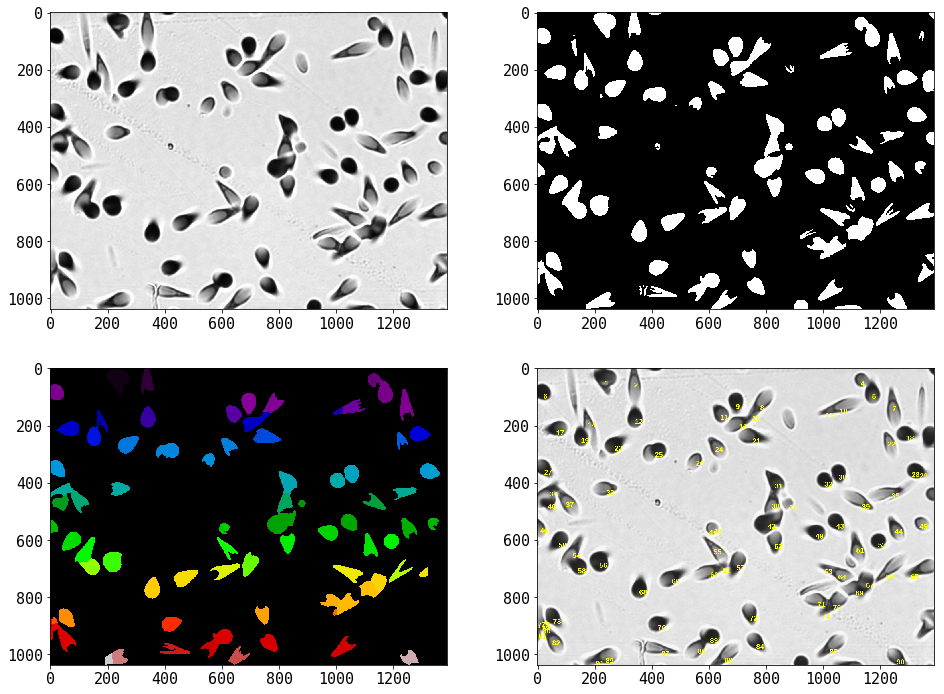

Number of tracks:  96


In [24]:
image = imread('figures/orig_figures/dataset_02/FT-Lab_19.07.384.MAG1.jpg', as_grey=True)
num_objects = sup.wusem_results(image,
                                initial_radius=10,
                                delta_radius=2,
                                save_images=False)
print('Number of tracks: ', num_objects)

In [25]:
mancount_dap = pd.read_excel('counting/manual_count/manual_dataset02.xls')
manual = {'MAG1': mancount_dap.query('image <= 9'),
          'MAG2': mancount_dap.query('image > 9')}

wusem_count_dap = pd.read_csv('counting/wusem_count/auto_dataset02.txt')
wusem = {'MAG1': wusem_count_dap.query('image <= 9'),
         'MAG2': wusem_count_dap.query('image > 9')}

In [26]:
# separating a test image.
wusem_daptest = wusem['MAG1'][wusem['MAG1']['image'] == 5]

In [27]:
# initial_radius starts in 5, ends in 40 and has delta_radius 5.
# delta_radius starts in 2, ends in 20 and has delta_radius 2.
# let's create matrices to accomodate the countings.

XX, YY = np.mgrid[5:41:5, 2:21:2]
ZZ_k0 = np.zeros(XX.shape)

for i, j in product(range(5, 41, 5), range(2, 21, 2)):
    aux = int(wusem_daptest.auto_count[(wusem_count_dap.initial_radius == i) & (wusem_count_dap.delta_radius == j)])
    ZZ_k0[(XX == i) & (YY == j)] = aux

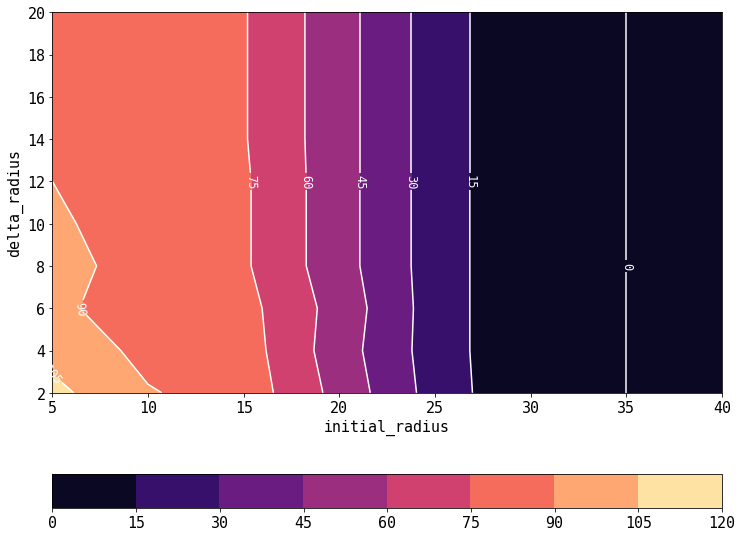

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))

image = ax.contour(ZZ_k0.T, colors='w')
ax.clabel(image, fmt='%i', fontsize=12)

image = ax.contourf(ZZ_k0.T, cmap='magma')

ax.set_xlabel('initial_radius')
ax.set_ylabel('delta_radius')
ax.set_xticklabels(('5', '10', '15', '20', '25', '30', '35', '40'))
ax.set_yticklabels(('2', '4', '6', '8', '10', '12', '14', '16', '18', '20'))

# fig.colorbar(image, ax=ax.tolist(), orientation='horizontal')
fig.colorbar(image, orientation='horizontal')

In [29]:
# calculating the means for manual counting, and obtaining the candidates for initial_radius and delta_radius.
mean_tol = 5  # defining tolerance
meanman_dap, wusem_dap = [{} for _ in range(2)]

for key, val in manual.items():
    meanman_dap[key] = val.manual_count.mean()
    wusem_dap[key] = ds.comp_wusem_counting(meanman_dap[key],
                                            wusem[key],
                                            tolerance=mean_tol)

In [30]:
print('Means for manual counting: ', meanman_dap, '\nBest candidates: ', wusem_dap)

Means for manual counting:  {'MAG1': 84.66666666666667, 'MAG2': 37.3} 
Best candidates:  {'MAG1': [[5, 12], [5, 14], [5, 16], [5, 18], [10, 2]], 'MAG2': [[10, 14], [10, 16], [10, 18], [10, 20], [15, 6], [15, 8], [15, 10], [15, 12], [15, 14], [15, 16], [15, 18], [15, 20], [20, 2], [20, 4], [20, 6], [20, 8], [20, 10], [20, 12]]}


(5, 25)

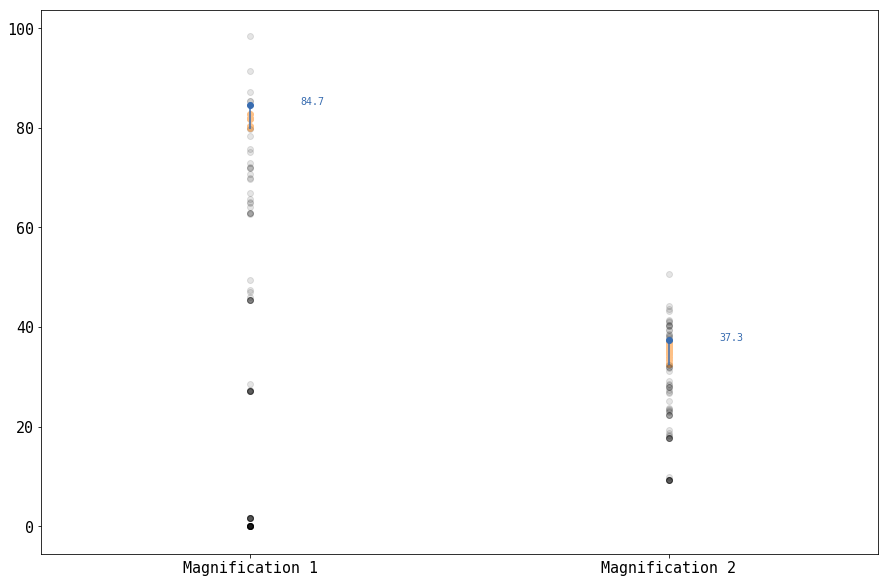

In [31]:
man_color = '#386cb0'
auto_color = '#fdc086'

plot_where = {'MAG1': 10, 'MAG2': 20}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

for key, val in meanman_dap.items():
    ax.errorbar(plot_where[key], val, yerr=np.array([[mean_tol, 0]]).T, marker='o', color=man_color)
    ax.annotate(np.round(val, decimals=1), xy=(plot_where[key]+1.2, val), color=man_color)

for i, j in product(range(5, 41, 5), range(2, 21, 2)):
    for key, val in wusem.items():
        aux = val.auto_count[(val.initial_radius == i) & (val.delta_radius == j)].mean()
        if 0 < (meanman_dap[key] - aux) < mean_tol:
            ax.scatter(plot_where[key], aux, color=auto_color)
        else:
            ax.scatter(plot_where[key], aux, color='k', alpha=0.1)

ticks = [10, 20]

ax.set_xticklabels(('Magnification 1', 'Magnification 2'))
ax.set_xticks(ticks)
ax.set_xlim([5, 25])

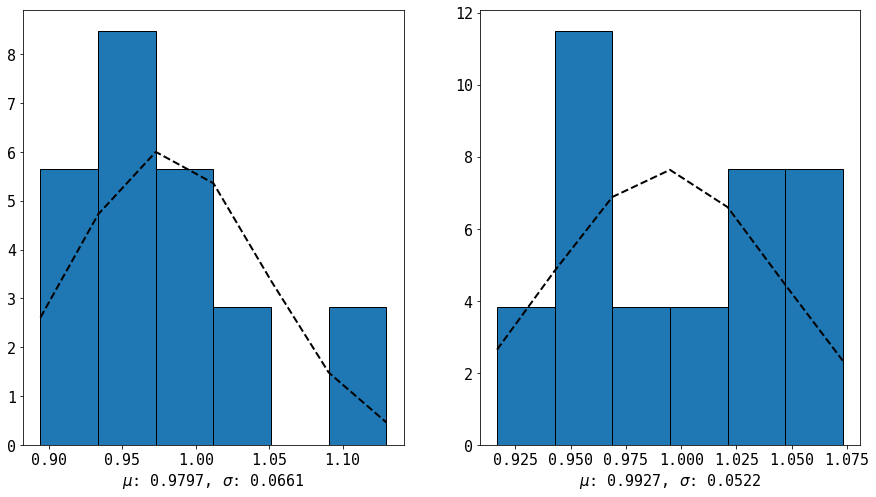

['MAG1', 0.9797358029159182, 0.06611686493845743]
['MAG2', 0.9927337909558706, 0.052203587304694384]


In [32]:
wusem_best_mag1 = wusem['MAG1'][(wusem['MAG1']['initial_radius'] == 5) & (wusem['MAG1']['delta_radius'] == 12)]
wusem_best_mag2 = wusem['MAG2'][(wusem['MAG2']['initial_radius'] == 10) & (wusem['MAG2']['delta_radius'] == 14)]

wusem_best = {'MAG1': wusem_best_mag1, 'MAG2': wusem_best_mag2}

ratio = ds.ratio_manauto(manual, wusem_best, sample='dataset02')

for rt in ratio:
    print(rt)

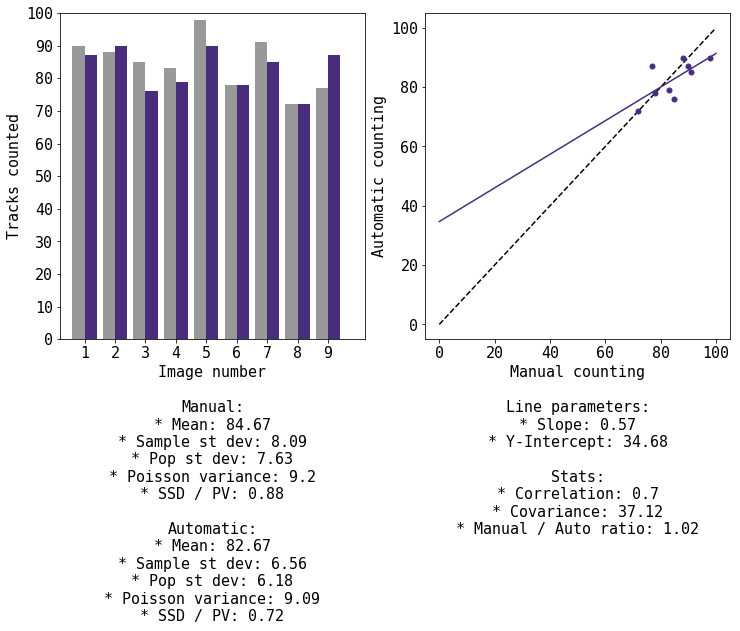

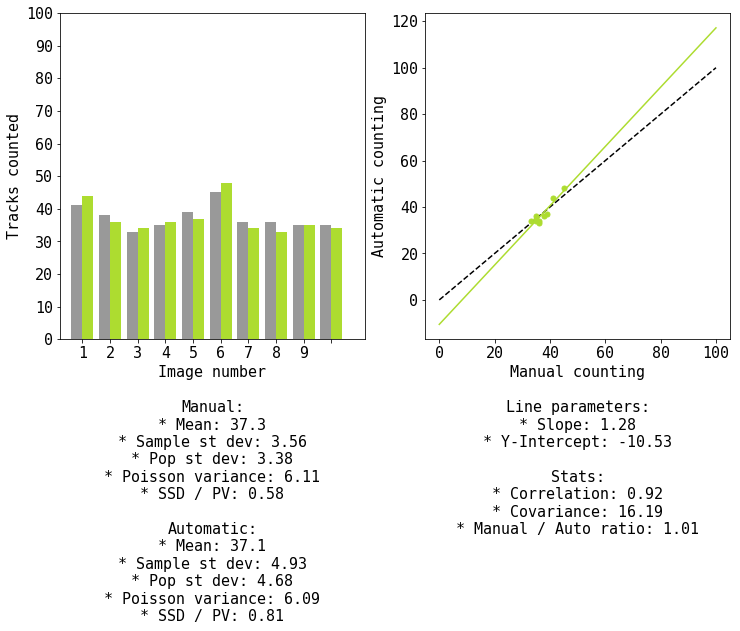

In [33]:
plot_where = {'MAG1': 10, 'MAG2': 20}
plot_colors = {'MAG1': '#472d7b', 'MAG2': '#addc30'}

for key, val in manual.items():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sup.plot_auxiliar_dataset2(var_manual=manual[key].manual_count,
                               var_auto=wusem_best[key].auto_count,
                               auto_color=plot_colors[key],
                               ax=ax[0])

    sup.plot_linreg_dataset2(var_manual=manual[key].manual_count,
                             var_auto=wusem_best[key].auto_count,
                             color=plot_colors[key],
                             ax=ax[1])

In [34]:
print('Manual, dataset 02')
for key, val in manual.items():
    print(key, ':', ds.parameters_samples(val.manual_count))
print('\n')

print('Auto, dataset 02')
for key, val in wusem_best.items():
    print(key, ':', ds.parameters_samples(val.auto_count))
print('\n')

Manual, dataset 02
MAG1 : [84.66666666666667, 7.630348761506398]
MAG2 : [37.3, 3.3778691508109078]


Auto, dataset 02
MAG1 : [82.66666666666667, 6.182412330330469]
MAG2 : [37.1, 4.678675026115834]




# Extras

## Comparing manual with classic watershed automatic counting.

* First, some helping variables. 

In [35]:
samples = ['0', '20', '30', '40', '50', '60', '70', '80', '90'] 
folders = ['K0_incid', 'K20_incid', 'K30_incid', 'K40_incid', 'K50_incid', 
           'K60_incid', 'K70_incid', 'K80_incid', 'K90_incid'] 

* Reading manual input data.

In [36]:
# dataset 01
manual_45, manual_85 = [{} for _ in range(2)]
man_count_45 = pd.read_excel('counting/manual_count/manual_dataset01_Kr-78_4,5min_incid.xls')
man_count_85 = pd.read_excel('counting/manual_count/manual_dataset01_Kr-78_8,5min_incid.xls')

# separating folders.
for idx, folder in enumerate(folders):
    manual_45[samples[idx]] = man_count_45[man_count_45['folder'] == folder]
    manual_85[samples[idx]] = man_count_85[man_count_85['folder'] == folder]

# dataset 02
mancount_dap = pd.read_excel('counting/manual_count/manual_dataset02.xls')
manual = {'MAG1': mancount_dap.query('image <= 9'),
          'MAG2': mancount_dap.query('image > 9')}

* Reading classic watershed input data.

In [37]:
# reading input data. 
water_count_45 = pd.read_csv('counting/water_count/water_dataset01_Kr-78_4,5min_incid.txt') 
water_count_85 = pd.read_csv('counting/water_count/water_dataset01_Kr-78_8,5min_incid.txt') 

# separating folders.
water_45, water_85 = [{} for _ in range(2)]

for idx, folder in enumerate(folders):
    water_45[samples[idx]] = water_count_45[water_count_45['folder'] == folder]
    water_85[samples[idx]] = water_count_85[water_count_85['folder'] == folder]

In [53]:
# comparing manual/auto mean and std
print('* Manual, dataset 01, 4.5 min')
for key, val in manual_45.items():
    print(key, ':', ds.parameters_samples(val.manual_count))
print('\n')

print('* Classic watershed, dataset 01, 4.5 min')
for key, val in water_45.items():
    print(key, ':', ds.parameters_samples(val.auto_count))
print('\n')

print('* Manual, dataset 01, 8.5 min')
for key, val in manual_85.items():
    print(key, ':', ds.parameters_samples(val.manual_count))
print('\n')

print('* Classic watershed, dataset 01, 8.5 min')
for key, val in water_85.items():
    print(key, ':', ds.parameters_samples(val.auto_count))
print('\n')

* Manual, dataset 01, 4.5 min
0 : [21.55, 3.4420197558991434]
20 : [25.35, 4.871088174114692]
30 : [23.2, 4.1424630354415966]
40 : [22.45, 3.8791107228332633]
50 : [24.35, 2.5743931323712004]
60 : [25.1, 3.144837038703278]
70 : [20.65, 4.065402809070708]
80 : [20.55, 3.6121323342314025]
90 : [23.545454545454547, 3.810598530024489]


* Classic watershed, dataset 01, 4.5 min
0 : [20.75, 3.1760824926314495]
20 : [23.25, 4.035777496344416]
30 : [21.85, 3.453621287865825]
40 : [21.5, 3.263433774416144]
50 : [22.9, 2.165640782770772]
60 : [23.95, 2.9576172842340505]
70 : [19.55, 3.761316258971053]
80 : [19.05, 3.3087006513131403]
90 : [23.363636363636363, 4.051323628210398]


* Manual, dataset 01, 8.5 min
0 : [19.85, 2.612948526090784]
20 : [22.2, 3.8288379438153295]
30 : [24.0, 4.135214625627067]
40 : [22.05, 4.466262419518136]
50 : [21.95, 4.00593309979086]
60 : [23.05, 3.879110722833263]
70 : [17.45, 4.09237095092808]
80 : [19.6, 4.5541190146942805]
90 : [21.45, 3.800986713999406]


* Cla

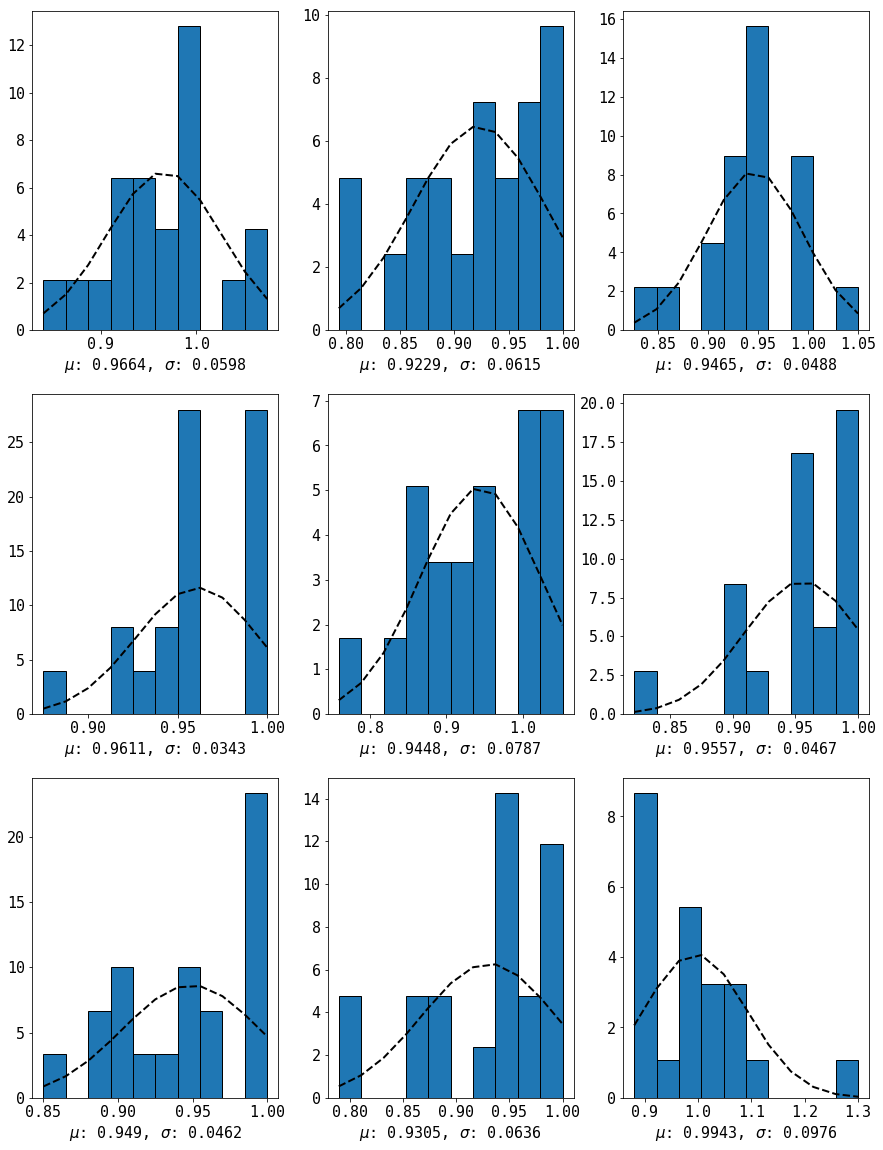

['0', 0.9664348096608325, 0.05977522449070813]
['20', 0.9228815691984733, 0.06149347884692974]
['30', 0.9464682749783948, 0.0488296160093589]
['40', 0.9610891845910599, 0.03432407142259716]
['50', 0.9448424760795548, 0.07870509330638668]
['60', 0.9556897551855386, 0.04667446473478168]
['70', 0.9490203152746058, 0.04621290380377003]
['80', 0.9305088867624199, 0.0635600069083393]
['90', 0.9942929887090447, 0.09761006449582858]


In [38]:
ratio = ds.ratio_manauto(manual_45, water_45)

# the values of mu and sigma for each sample:
for rt in ratio:
    print(rt)

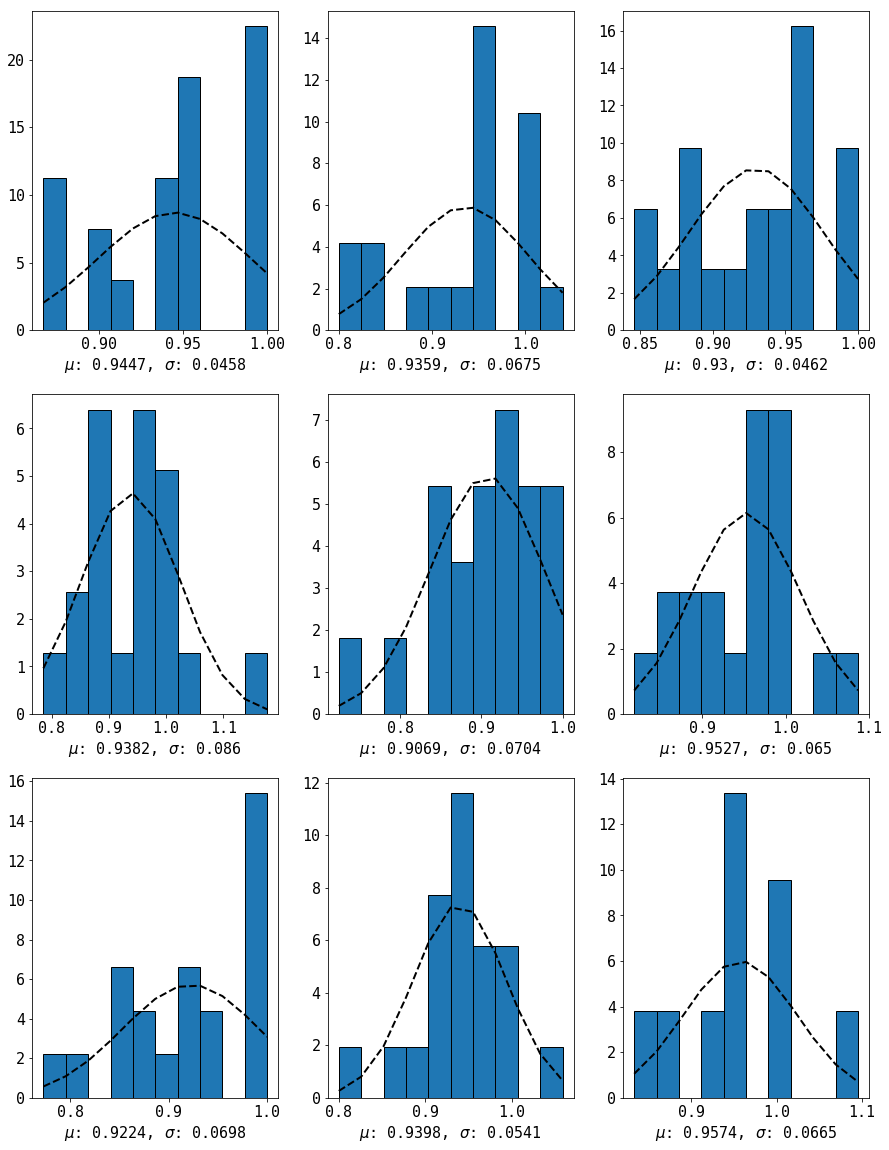

['0', 0.9447091829589471, 0.04583369039911559]
['20', 0.9359329578908027, 0.06748059894231662]
['30', 0.9300036586220797, 0.04621374914410144]
['40', 0.938225687668476, 0.0859633650748285]
['50', 0.9069428840154006, 0.07039246445656336]
['60', 0.9527137726344886, 0.0649813193919184]
['70', 0.9224194631334723, 0.06975524047326313]
['80', 0.9397876178925445, 0.05408083437474945]
['90', 0.9573817785652823, 0.06653501444265546]


In [39]:
ratio = ds.ratio_manauto(manual_85, water_85)

# the values of mu and sigma for each sample:
for rt in ratio:
    print(rt)

In [40]:
water_count_dap = pd.read_csv('counting/water_count/water_dataset02.txt')
water = {'MAG1': water_count_dap.query('image <= 392'),
         'MAG2': water_count_dap.query('image > 392')}

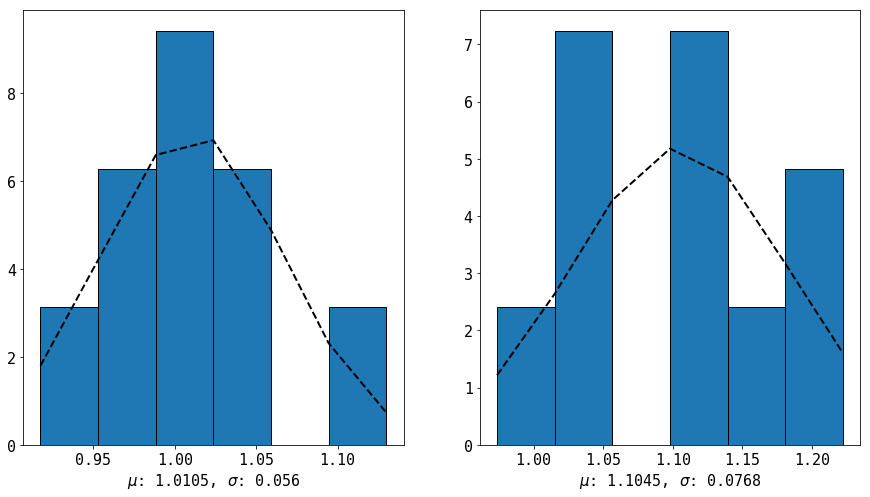

['MAG1', 1.0104742115592238, 0.05596679489729654]
['MAG2', 1.1044598120464617, 0.07675817288750077]


In [41]:
ratio = ds.ratio_manauto(manual, water, sample='dataset02')

for rt in ratio:
    print(rt)

In [58]:
print('Manual, dataset 02')
for key, val in manual.items():
    print(key, ':', ds.parameters_samples(val.manual_count))
print('\n')

print('Classic watershed, dataset 02')
for key, val in water.items():
    print(key, ':', ds.parameters_samples(val.auto_count))
print('\n')

Manual, dataset 02
MAG1 : [84.66666666666667, 7.630348761506398]
MAG2 : [37.3, 3.3778691508109078]


Classic watershed, dataset 02
MAG1 : [85.33333333333333, 6.5659052011974035]
MAG2 : [41.1, 3.753664875824692]




## Comparing manual with H-watershed automatic counting.

In [42]:
# reading input data. 
hwater_count_45 = pd.read_csv('counting/hwater_count/hwater_dataset01_Kr-78_4,5min_incid.txt') 
hwater_count_85 = pd.read_csv('counting/hwater_count/hwater_dataset01_Kr-78_8,5min_incid.txt') 

# separating folders.
hwater_45, hwater_85 = [{} for _ in range(2)]

for idx, folder in enumerate(folders):
    hwater_45[samples[idx]] = hwater_count_45[hwater_count_45['folder'] == folder]
    hwater_85[samples[idx]] = hwater_count_85[hwater_count_85['folder'] == folder]

# calculating the means for manual counting, and obtaining the candidates
# for seed.  
mean_tol = 2  # defining tolerance 
meanman_45, meanman_85 = [{} for _ in range(2)] 
cand_hwater_45, cand_hwater_85 = [{} for _ in range(2)] 

for key, val in manual_45.items():
    # candidates for 4,5 min. 
    meanman_45[key] = val.manual_count.mean() 
    cand_hwater_45[key] = sup.comp_hwater_counting(meanman_45[key],
                                                   hwater_45[key], 
                                                   tolerance=mean_tol)

for key, val in manual_85.items(): 
    # candidates for 8,5 min. 
    meanman_85[key] = val.manual_count.mean() 
    cand_hwater_85[key] = sup.comp_hwater_counting(meanman_85[key], 
                                                   hwater_85[key], 
                                                   tolerance=mean_tol)



In [43]:
print('* Means for manual counting (4.5 min):\n', meanman_45)
for cand in ds.sorting_candidates(ds.joining_candidates(cand_hwater_45)):
    print('Candidate: ', cand[0], ', Samples: ', cand[1])
print('\n')

print('* Means for manual counting (8.5 min):\n', meanman_85)
for cand in ds.sorting_candidates(ds.joining_candidates(cand_hwater_85)):
    print('Candidate: ', cand[0], ', Samples: ', cand[1])
print('\n')

* Means for manual counting (4.5 min):
 {'0': 21.55, '20': 25.35, '30': 23.2, '40': 22.45, '50': 24.35, '60': 25.1, '70': 20.65, '80': 20.55, '90': 23.545454545454547}
Candidate:  [5] , Samples:  3
Candidate:  [6] , Samples:  3
Candidate:  [4] , Samples:  2
Candidate:  [7] , Samples:  2
Candidate:  [10] , Samples:  1
Candidate:  [11] , Samples:  1
Candidate:  [13] , Samples:  1
Candidate:  [14] , Samples:  1


* Means for manual counting (8.5 min):
 {'0': 19.85, '20': 22.2, '30': 24.0, '40': 22.05, '50': 21.95, '60': 23.05, '70': 17.45, '80': 19.6, '90': 21.45}
Candidate:  [5] , Samples:  3
Candidate:  [6] , Samples:  2
Candidate:  [7] , Samples:  1
Candidate:  [12] , Samples:  1




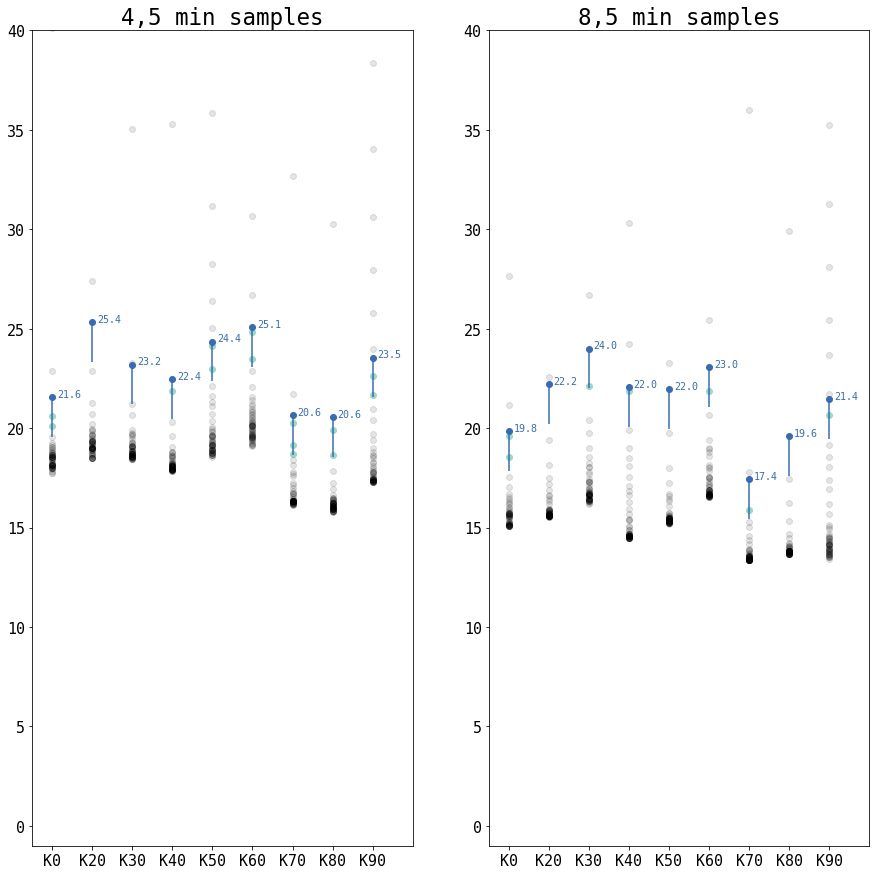

In [44]:
# supporting variables.
man_color = '#386cb0'
hwater_color = '#99d8c9'

plot_where = {'0': 10, '20': 20, '30': 30, '40': 40, '50': 50,
                 '60': 60, '70': 70, '80': 80, '90': 90}

x_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90]
x_labels = ['K0', 'K20', 'K30', 'K40', 'K50', 'K60', 'K70', 'K80', 'K90']

# the actual plots.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

for key, val in meanman_45.items():
    axes[0].errorbar(plot_where[key], val, yerr=np.array([[mean_tol, 0]]).T, marker='o', color=man_color)
    axes[0].annotate(np.round(val, decimals=1), xy=(plot_where[key]+1.2, val), color=man_color)
    axes[0].set_title('4,5 min samples')

for key, val in meanman_85.items():
    axes[1].errorbar(plot_where[key], val, yerr=np.array([[mean_tol, 0]]).T, marker='o', color=man_color)
    axes[1].annotate(np.round(val, decimals=1), xy=(plot_where[key]+1.2, val), color=man_color)
    axes[1].set_title('8,5 min samples')

for idx in range(1, 61):
    for key, val in hwater_45.items():
        aux_hwater = val.auto_count[val.seed == idx].mean()
        if 0 < (meanman_45[key] - aux_hwater) < mean_tol:
            axes[0].scatter(plot_where[key], aux_hwater, color=hwater_color)
        else:
            axes[0].scatter(plot_where[key], aux_hwater, color='k', alpha=0.1)

    for key, val in hwater_85.items():
        aux_hwater = val.auto_count[val.seed == idx].mean()
        if 0 < (meanman_85[key] - aux_hwater) < mean_tol:
            axes[1].scatter(plot_where[key], aux_hwater, color=hwater_color)
        else:
            axes[1].scatter(plot_where[key], aux_hwater, color='k', alpha=0.1)

for ax in axes.ravel():
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    ax.set_xlim([5, 100])
    ax.set_ylim([-1, 40])

* According to the previous information, we define the best seed:

In [45]:
bestseed = 5

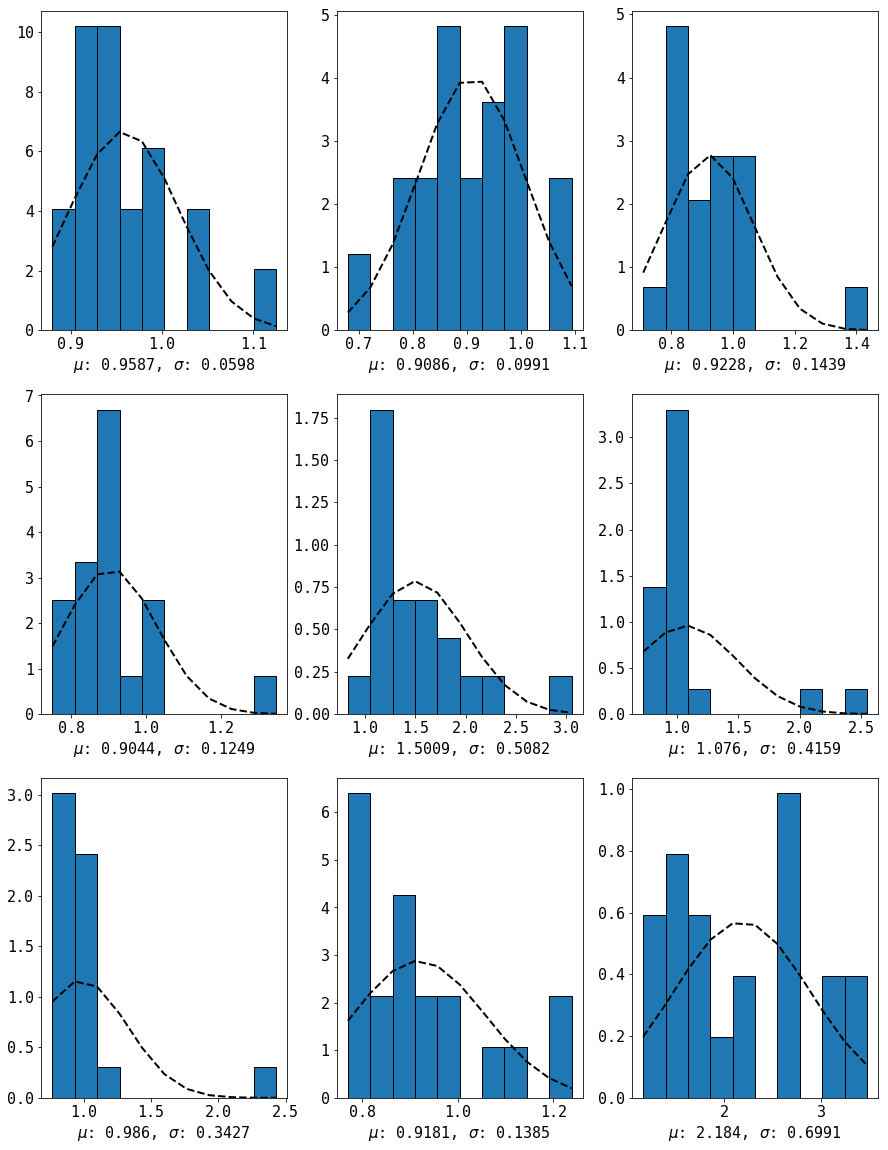

['0', 0.9586582188482511, 0.05978224885300506]
['20', 0.9086093983304441, 0.09912779255709034]
['30', 0.9228059875323742, 0.14389613361083237]
['40', 0.9043919141731406, 0.1249379234411395]
['50', 1.5009288079275058, 0.5082066020107571]
['60', 1.0759773995269584, 0.41592998229997147]
['70', 0.9860043277025541, 0.3427133835518538]
['80', 0.9180575757530933, 0.13854466029136744]
['90', 2.184033665769452, 0.6991297794201302]


In [46]:
# 4.5 minutes:
hwaterbest_45 = {}

for key, val in hwater_45.items():
    hwaterbest_45[key] = val[val['seed'] == bestseed]

ratio = ds.ratio_manauto(manual_45, hwaterbest_45)

# the values of mu and sigma for each sample:
for rt in ratio:
    print(rt)

In [55]:
# comparing manual/auto mean and std
print('* Manual, dataset 01, 4.5 min')
for key, val in manual_45.items():
    print(key, ':', ds.parameters_samples(val.manual_count))
print('\n')

print('* H-watershed, dataset 01, 4.5 min')
for key, val in hwaterbest_45.items():
    print(key, ':', ds.parameters_samples(val.auto_count))
print('\n')

print('* Manual, dataset 01, 8.5 min')
for key, val in manual_85.items():
    print(key, ':', ds.parameters_samples(val.manual_count))
print('\n')

print('* H-watershed, dataset 01, 8.5 min')
for key, val in hwaterbest_85.items():
    print(key, ':', ds.parameters_samples(val.auto_count))
print('\n')

* Manual, dataset 01, 4.5 min
0 : [21.55, 3.4420197558991434]
20 : [25.35, 4.871088174114692]
30 : [23.2, 4.1424630354415966]
40 : [22.45, 3.8791107228332633]
50 : [24.35, 2.5743931323712004]
60 : [25.1, 3.144837038703278]
70 : [20.65, 4.065402809070708]
80 : [20.55, 3.6121323342314025]
90 : [23.545454545454547, 3.810598530024489]


* H-watershed, dataset 01, 4.5 min
0 : [20.6, 3.246536616149586]
20 : [22.85, 4.452808102759426]
30 : [21.2, 4.007492981902775]
40 : [20.3, 4.670117771534247]
50 : [35.85, 9.712234552357147]
60 : [26.7, 9.182047701901793]
70 : [20.25, 7.8668608733089975]
80 : [18.65, 3.365635155509284]
90 : [52.95454545454545, 24.05765286051457]


* Manual, dataset 01, 8.5 min
0 : [19.85, 2.612948526090784]
20 : [22.2, 3.8288379438153295]
30 : [24.0, 4.135214625627067]
40 : [22.05, 4.466262419518136]
50 : [21.95, 4.00593309979086]
60 : [23.05, 3.879110722833263]
70 : [17.45, 4.09237095092808]
80 : [19.6, 4.5541190146942805]
90 : [21.45, 3.800986713999406]


* H-watershed, d

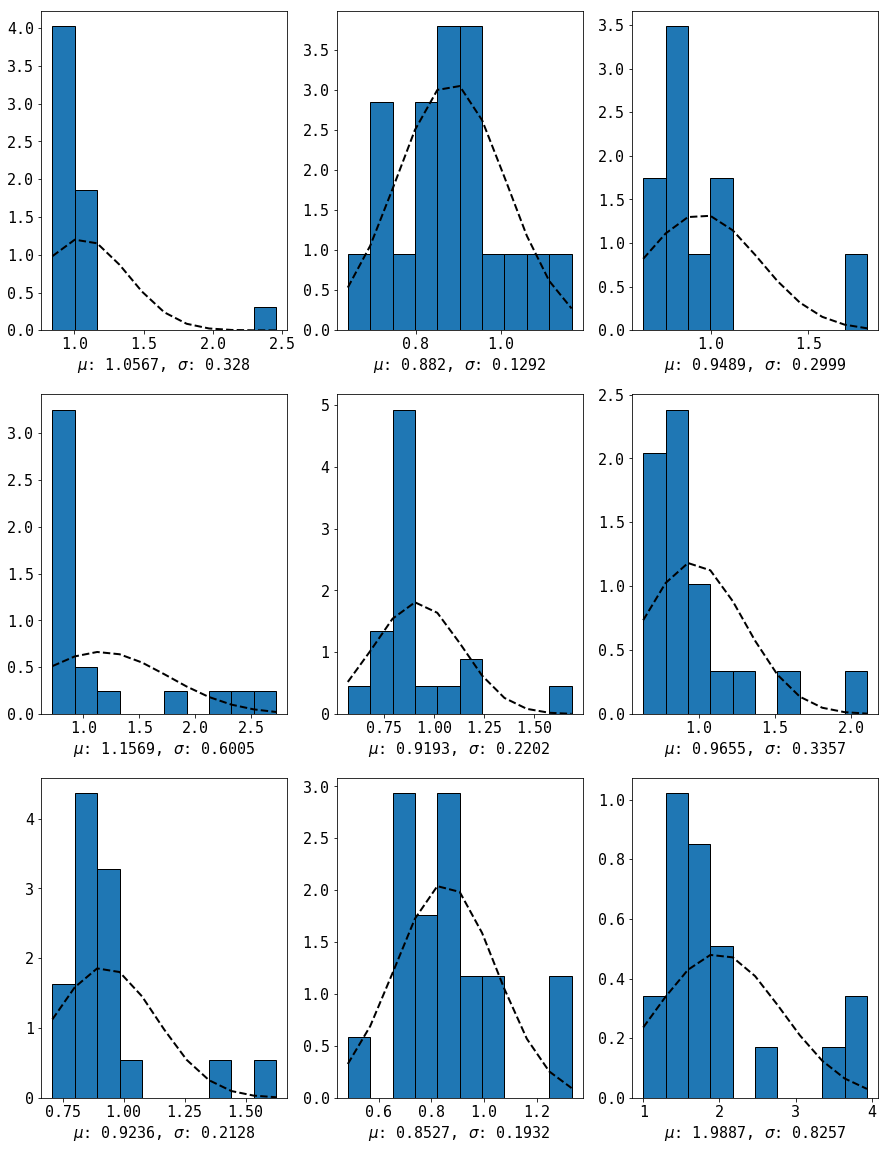

['0', 1.0567015828057018, 0.3279597011816782]
['20', 0.8820496801827409, 0.1291953536971168]
['30', 0.9488526871520294, 0.29990902929173924]
['40', 1.156862316771488, 0.600530730629256]
['50', 0.9192776471301828, 0.22018465231223788]
['60', 0.9655425669363614, 0.3356573776779668]
['70', 0.923557616918685, 0.21280176413898028]
['80', 0.8527273196036154, 0.19317361575807568]
['90', 1.9887375362276258, 0.8256967348313792]


In [47]:
# 8.5 minutes:
hwaterbest_85 = {}

for key, val in hwater_85.items():
    hwaterbest_85[key] = val[val['seed'] == bestseed]

ratio = ds.ratio_manauto(manual_85, hwaterbest_85)

# the values of mu and sigma for each sample:
for rt in ratio:
    print(rt)

In [48]:
hwater_count_dap = pd.read_csv('counting/hwater_count/hwater_dataset02.txt')
hwater = {'MAG1': hwater_count_dap.query('image <= 392'),
          'MAG2': hwater_count_dap.query('image > 392')}

In [49]:
# calculating the means for manual counting, and obtaining the candidates for initial_radius and delta_radius.
mean_tol = 5  # defining tolerance
meanman_dap, hwater_dap = [{} for _ in range(2)]

for key, val in manual.items():
    meanman_dap[key] = val.manual_count.mean()
    hwater_dap[key] = sup.comp_hwater_counting(meanman_dap[key],
                                               hwater[key],
                                               tolerance=mean_tol)

In [50]:
print('Means for manual counting: ', meanman_dap, '\nBest candidates: ', hwater_dap)

Means for manual counting:  {'MAG1': 84.66666666666667, 'MAG2': 37.3} 
Best candidates:  {'MAG1': [[19], [20], [21]], 'MAG2': [[23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58]]}


(5, 25)

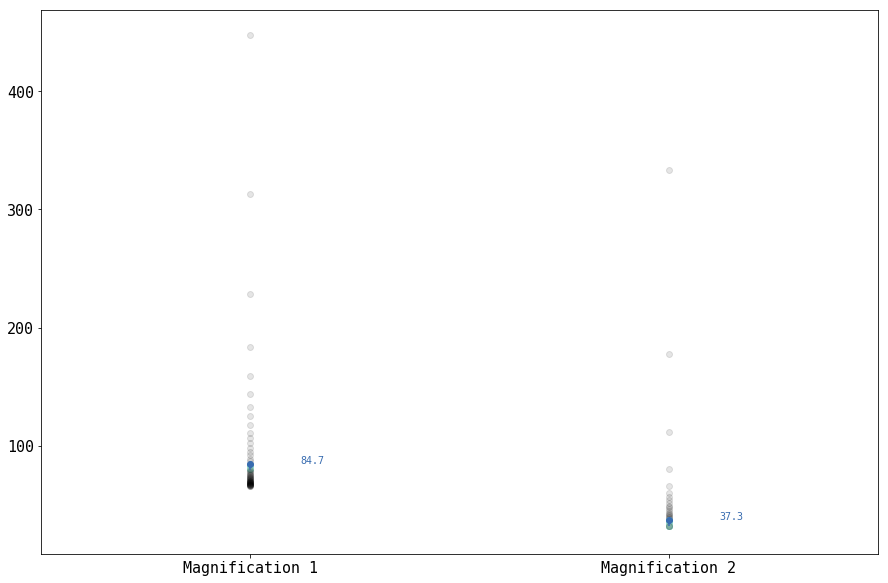

In [51]:
man_color = '#386cb0'
hwater_color = '#99d8c9'

plot_where = {'MAG1': 10, 'MAG2': 20}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

for key, val in meanman_dap.items():
    ax.errorbar(plot_where[key], val, yerr=np.array([[mean_tol, 0]]).T, marker='o', color=man_color)
    ax.annotate(np.round(val, decimals=1), xy=(plot_where[key]+1.2, val), color=man_color)

for idx in range(1, 61):
    for key, val in hwater.items():
        aux_hwater = val.auto_count[val.seed == idx].mean()
        if 0 < (meanman_dap[key] - aux_hwater) < mean_tol:
            ax.scatter(plot_where[key], aux_hwater, color=hwater_color)
        else:
            ax.scatter(plot_where[key], aux_hwater, color='k', alpha=0.1)

ticks = [10, 20]

ax.set_xticklabels(('Magnification 1', 'Magnification 2'))
ax.set_xticks(ticks)
ax.set_xlim([5, 25])

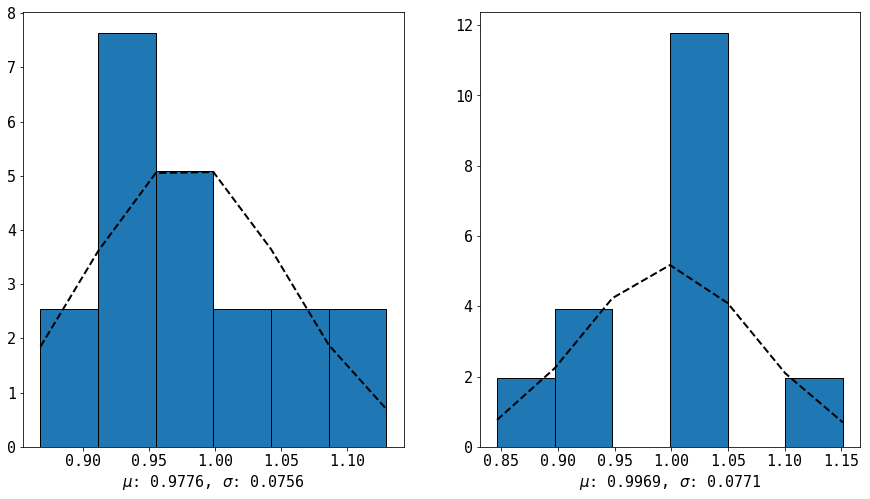

['MAG1', 0.9776146888546065, 0.0756283943973723]
['MAG2', 0.9969068023689334, 0.07708759995888663]


In [52]:
hwater_best_mag1 = hwater['MAG1'][hwater['MAG1']['seed'] == 19]
hwater_best_mag2 = hwater['MAG2'][hwater['MAG2']['seed'] == 23]

hwater_best = {'MAG1': hwater_best_mag1, 'MAG2': hwater_best_mag2}

ratio = ds.ratio_manauto(manual, hwater_best, sample='dataset02')

for rt in ratio:
    print(rt)

In [57]:
print('Manual, dataset 02')
for key, val in manual.items():
    print(key, ':', ds.parameters_samples(val.manual_count))
print('\n')

print('H-watershed, dataset 02')
for key, val in hwater_best.items():
    print(key, ':', ds.parameters_samples(val.auto_count))
print('\n')

Manual, dataset 02
MAG1 : [84.66666666666667, 7.630348761506398]
MAG2 : [37.3, 3.3778691508109078]


H-watershed, dataset 02
MAG1 : [82.66666666666667, 8.86942313043338]
MAG2 : [37.0, 2.32379000772445]


